In this iPython notebook, we will featurize MOR ligand binding simulation by pairwise distances between the ligand and different receptor residues. We will then perform tICA and prospectively build an MSM. 

In [1]:
from PDB_Order_Fixer import PDB_Order_Fixer
import mdtraj as md
import os
import numpy as np
import h5py

import datetime
import glob
import copy
from functools import partial 
import operator
import time

import random 
import subprocess
from subprocess import Popen
import sys
from io_functions import *
from custom_clusterer import *
from custom_tica import *
from custom_featurizer import *
from pdb_editing import *
from analysis import *
from io_functions import *
#from topology_fixing import *
from subsampling import *
from conversions import *
from custom_msm import *
from grids import *
from docking_analysis import *

In [2]:
from detect_intermediates import *
from interpret_tICs import *

In [3]:
from b2ar_feature_types import *
from get_variable_names import *
from b2ar_tica_config import *
from residue import Residue, Atom

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt

#set_palette('Set1', n_colors=15, desat=None)

In [5]:
ori_feature_name = copy.deepcopy(feature_name)

In [6]:
schemes = ["closest-heavy", "CA"]
feature_name = "%s-CA_py3" %ori_feature_name

In [7]:
rho = 0.01
rho_string = "_rho0pt01"

n_components=10
n_clusters=100
lag_time = 50

In [8]:
(active_ref_dir, inactive_ref_dir, simulation_ref_dir, scripts_dir,
          ligand_dir, agonist_dir, inverse_agonist_dir, biased_agonist_dir, ref_receptors_dir, whole_trajectory_pnas,
          sasa_file) = get_base_files(base)

tica_dir = get_tica_dir(base, is_sparse, lag_time, n_components, feature_name, 
                                 wolf_string, shrinkage_string, rho_string)
ori_tica_dir = copy.deepcopy(tica_dir)
features_dir = get_features_dir(base, feature_name)

landmarks_dir = get_landmarks_dir(tica_dir)
analysis_dir = get_analysis_dir(tica_dir, n_clusters, sampling_method)
gmm_dir = get_gmm_dir(tica_dir)
rf_dirdir = get_rf_dir(tica_dir)


ref_tica_dir, ref_tica_coords = get_ref_tica_dirs(tica_dir)

graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)

pnas_titles =  ["tm6_tm3_dist", "rmsd_npxxy_inactive", "rmsd_npxxy_active", "rmsd_connector_inactive", "rmsd_connector_active"]
pnas_features_dir = analysis_dir


(clusterer_dir, msm_model_dir, macrostate_dir, features_known, model_dir, projected_features_dir,
         projection_operator_dir, ktica_fit_model_filename, ktica_projected_data_filename, nystroem_data_filename,
         mutual_information_csv, pearson_csv) = get_tica_files(base, tica_dir, n_clusters, msm_lag_time, n_macrostates)

(standardized_features_dir, feature_residues_csv, feature_residues_pkl,
          contact_csv, ref_features_dir) = get_feature_files(features_dir)

(kmeans_csv, tica_coords_csv, features_csv, active_rmsd_dir, inactive_rmsd_dir, active_pnas_dir, inactive_pnas_joined, active_pnas_joined,
        clusters_map_file, ktica_clusters_map_file, analysis_file, combined_file, docking_summary, docking_joined, docking_z_scores_csv,
        aggregate_docking, aggregate_docking_joined, docking_pnas_joined, aggregate_docking_pnas, aggregate_docking_pnas_joined, docking_multiple_ligands,
        docking_distances_file, docking_pdf, mmgbsa_docking_distances, pnas_coords, mmgbsa_dir, mmgbsa_csv, mmgbsa_pdf, aggregate_mmgbsa,
        aggregate_mmgbsa_joined, aggregate_mmgbsa_pnas_joined, mmgbsa_z_scores_csv, active_clusters_csv, intermediate_clusters_csv,
        inactive_clusters_csv, pnas_clusters_averages, tica_clusters_averages, tica_classes_csv, tica_samples_csv, subgraph_save_base,
        degree_save_base, degree_map_csv, degree_z_map_csv, aggregate_docking_pnas_degree_z_joined, tic_residue_csv, feature_coefs_csv,
        duplicated_feature_coefs_csv) = get_analysis_files(analysis_dir, n_clusters, tica_dir, tica_dir, sampling_method, n_samples, precision,
                                                           msm_lag_time)

(inactive_pnas_distances_dir, active_pnas_distances_dir, active_pnas_all_distances_dir,
          inactive_pnas_distances_new_csv, active_pnas_distances_new_csv, active_pnas_joined, active_pnas_means, pnas_coords_dir,
          pnas_coords_csv, pnas_all_coords_csv, pnas_coords_hexbin_dir, pnas_coords_co_crystallized_docking_dir,
          pnas_coords_active_colors_dir, user_defined_features_file, reaction_coordinates_trajs_file) = get_pnas_files(whole_trajectory_pnas, pnas_features_dir)

features_dir = get_features_dir(base, feature_name)



graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)
(scripts_dir, pymol_fixpdb_dir) = get_script_dir(scripts_dir)
(save_dir, reimaged_dir, mae_dir, combined_reimaged_dir, grid_dir, docking_dir) = get_docking_dirs(tica_dir, n_clusters, n_components, n_samples, sampling_method, precision)


/home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A-CA_py3
/home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A-CA_py3


In [9]:
tica_dir

'/home/enf/b2ar_analysis/sparse-tICA_t50_n_components10all_residues_2rh1_3sn6_under_cutoff6A-CA_py3_regularization_wolf_autoShrinkage_rho0pt01'

In [10]:
cutoff

0.66

In [11]:
schemes

['closest-heavy', 'CA']

In [12]:
contact_residues

[A29,
 A30,
 A31,
 A32,
 A33,
 A34,
 A35,
 A36,
 A37,
 A38,
 A39,
 A40,
 A41,
 A42,
 A43,
 A44,
 A45,
 A46,
 A47,
 A48,
 A49,
 A50,
 A51,
 A52,
 A53,
 A54,
 A55,
 A56,
 A57,
 A58,
 A59,
 A60,
 A61,
 A62,
 A63,
 A64,
 A65,
 A66,
 A67,
 A68,
 A69,
 A70,
 A71,
 A72,
 A73,
 A74,
 A75,
 A76,
 A77,
 A78,
 A79,
 A80,
 A81,
 A82,
 A83,
 A84,
 A85,
 A86,
 A87,
 A88,
 A89,
 A90,
 A91,
 A92,
 A93,
 A94,
 A95,
 A96,
 A97,
 A98,
 A99,
 A100,
 A101,
 A102,
 A103,
 A104,
 A105,
 A106,
 A107,
 A108,
 A109,
 A110,
 A111,
 A112,
 A113,
 A114,
 A115,
 A116,
 A117,
 A118,
 A119,
 A120,
 A121,
 A122,
 A123,
 A124,
 A125,
 A126,
 A127,
 A128,
 A129,
 A130,
 A131,
 A132,
 A133,
 A134,
 A135,
 A136,
 A137,
 A138,
 A139,
 A140,
 A141,
 A142,
 A143,
 A144,
 A145,
 A146,
 A147,
 A148,
 A149,
 A150,
 A151,
 A152,
 A153,
 A154,
 A155,
 A156,
 A157,
 A158,
 A159,
 A160,
 A161,
 A162,
 A163,
 A164,
 A165,
 A166,
 A167,
 A168,
 A169,
 A170,
 A171,
 A172,
 A173,
 A174,
 A175,
 A176,
 A177,
 A178,
 A179,
 A180,
 A181,


In [13]:
if not os.path.exists(features_dir): os.makedirs(features_dir)
from custom_featurizer import *
featurize_contacts_custom(traj_dir, features_dir = features_dir, 
                          traj_ext = traj_ext, contact_residue_pairs_file = feature_residues_pkl, 
                          structures = [active_ref_dir, inactive_ref_dir],
                          contact_residues =  contact_residues, residues_map = None, 
                          contact_cutoff = cutoff, parallel = False, 
                          exacycle = False, load_from_file=False, schemes=schemes, worker_pool=None,
                          binarize=None)


already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already feat

/vspdata/vspcompute/home/enf/software/mdtraj_chain_works/mdtraj/geometry/contact.py:155: UserWarning: Ignoring contacts pair 207-210. No alpha carbon.
  warnings.warn('Ignoring contacts pair %d-%d. No alpha carbon.' % (r0, r1))
/vspdata/vspcompute/home/enf/software/mdtraj_chain_works/mdtraj/geometry/contact.py:155: UserWarning: Ignoring contacts pair 207-211. No alpha carbon.
  warnings.warn('Ignoring contacts pair %d-%d. No alpha carbon.' % (r0, r1))
/vspdata/vspcompute/home/enf/software/mdtraj_chain_works/mdtraj/geometry/contact.py:155: UserWarning: Ignoring contacts pair 207-208. No alpha carbon.
  warnings.warn('Ignoring contacts pair %d-%d. No alpha carbon.' % (r0, r1))
/vspdata/vspcompute/home/enf/software/mdtraj_chain_works/mdtraj/geometry/contact.py:155: UserWarning: Ignoring contacts pair 207-209. No alpha carbon.
  warnings.warn('Ignoring contacts pair %d-%d. No alpha carbon.' % (r0, r1))
/vspdata/vspcompute/home/enf/software/mdtraj_chain_works/mdtraj/geometry/contact.py:155:

There are 4551 features to be used in featurization.
Saving contact feature residue pairs to disk.
About to featurize trajectories based on the chosen featurization scheme.
[ALA119 to ALA78, ALA119 to ASP79, ALA119 to CYS116, ALA119 to GLU122, ALA119 to ILE121, ALA119 to LEU115, ALA119 to LEU124, ALA119 to LEU75, ALA119 to MET82, ALA119 to SER120, ALA119 to SER161, ALA119 to SER207, ALA119 to SER74, ALA119 to THR118, ALA119 to THR123, ALA119 to TRP158, ALA119 to VAL114, ALA119 to VAL117, ALA119 to VAL157, ALA128 to ARG131, ALA128 to ASP130, ALA128 to CYS125, ALA128 to GLU122, ALA128 to ILE127, ALA128 to ILE135, ALA128 to ILE214, ALA128 to ILE278, ALA128 to LEU124, ALA128 to MET215, ALA128 to MET279, ALA128 to PHE133, ALA128 to THR123, ALA128 to TYR132, ALA128 to TYR219, ALA128 to TYR326, ALA128 to VAL126, ALA128 to VAL129, ALA128 to VAL216, ALA128 to VAL218, ALA128 to VAL222, ALA134 to ARG131, ALA134 to ASP130, ALA134 to GLN142, ALA134 to ILE135, ALA134 to LEU144, ALA134 to LYS140, ALA

In [ ]:
fit_normalizer(features_dir)

loading /home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A-CA_py3/A-00.dataset
loading /home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A-CA_py3/A-01.dataset
loading /home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A-CA_py3/A-02.dataset
loading /home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A-CA_py3/A-03.dataset
loading /home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A-CA_py3/A-04.dataset
loading /home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A-CA_py3/A-05.dataset
loading /home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A-CA_py3/A-06.dataset
loading /home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A-CA_py3/A-07.dataset
loading /home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A-CA_py3/A-08.dataset
loading /home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A-CA_py3/A-09.dataset
loading /home/enf/b2

In [ ]:
fit_and_transform(features_directory = features_dir,
                  model_dir = tica_dir, stride=5,
                  lag_time = lag_time, n_components = n_components,
                  sparse = sparse, wolf = wolf, rho = rho, shrinkage = shrinkage,
                  parallel=True, traj_ext = traj_ext, normalize=True, partial_fit=True)

loading feature files
fitting tICA model to /home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A-CA_py3/A-00.dataset
loading /home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A-CA_py3/A-00.dataset
fitting tICA model to /home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A-CA_py3/A-01.dataset
loading /home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A-CA_py3/A-01.dataset
fitting tICA model to /home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A-CA_py3/A-02.dataset
loading /home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A-CA_py3/A-02.dataset
fitting tICA model to /home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A-CA_py3/A-03.dataset
loading /home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A-CA_py3/A-03.dataset
fitting tICA model to /home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A-CA_py3/A-04.dataset
loading /home/enf/b2ar_ana

In [15]:
tica_object = verboseload(projection_operator_dir)
print(tica_object.timescales_)

loading "/home/enf/b2ar_analysis/sparse-tICA_t50_n_components10all_residues_2rh1_3sn6_under_cutoff6A-CA_py3_regularization_wolf_autoShrinkage_rho0pt01/phi_psi_chi2_allprot_tica_coords.h5"...
[ 4453.35831254  2636.95941981  2032.11920332  1938.61533052  1417.85230032
  1054.55509923  1054.29975978   941.35861014   827.02083982   769.71935224]


In [16]:
tic_components_dir = tica_dir
important_contact_features = interpret_tIC_components(projection_operator_dir, tic_components_dir, feature_residues_pkl, n_tica_components=n_components, percentile=95)

Interpreting tIC 1
feature_importances_df.shape
(6, 5)
residue_importances_df.shape
(9, 2)
            feature_name     res_i      res_j  importance  \
1        Asp79 To Tyr326     Asp79     Tyr326    0.437833   
0        Asn318 To Asp79    Asn318      Asp79    0.265661   
5  Ile47_Ca To Pro323_Ca  Ile47_Ca  Pro323_Ca    0.145325   
2  Ala76_Ca To Pro323_Ca  Ala76_Ca  Pro323_Ca   -0.127310   
3  Asp79_Ca To Tyr326_Ca  Asp79_Ca  Tyr326_Ca   -0.113536   
4  Ile47_Ca To Phe321_Ca  Ile47_Ca  Phe321_Ca   -0.112529   

                 feature  
1        ASP79 to TYR326  
0        ASN318 to ASP79  
5  ILE47_CA to PRO323_CA  
2  ALA76_CA to PRO323_CA  
3  ASP79_CA to TYR326_CA  
4  ILE47_CA to PHE321_CA  
Using dark_background


/vspdata/vspcompute/home/enf/b2ar_analysis/conformation/interpret_tICs.py:97: FutureWarning: order is deprecated, use sort_values(...)
  df = df.reindex(df_copy.importance.abs().order(ascending=False).index)


             residue  importance
Tyr326        Tyr326    0.437833
Asp79          Asp79    0.429224
Asn318        Asn318    0.265661
Ile47_Ca    Ile47_Ca    0.132433
Pro323_Ca  Pro323_Ca    0.131694
Ala76_Ca    Ala76_Ca   -0.127310
Tyr326_Ca  Tyr326_Ca   -0.113536
Asp79_Ca    Asp79_Ca   -0.113536
Phe321_Ca  Phe321_Ca   -0.112529
Using dark_background
Interpreting tIC 2
feature_importances_df.shape
(5, 5)
residue_importances_df.shape
(8, 2)
             feature_name      res_i      res_j  importance  \
4  Gln170_Ca To Phe104_Ca  Gln170_Ca  Phe104_Ca   -0.533233   
0         Cys190 To His93     Cys190      His93    0.467251   
1         Cys191 To His93     Cys191      His93    0.354004   
3   Cys191_Ca To His93_Ca  Cys191_Ca   His93_Ca   -0.218551   
2         His93 To Ile309      His93     Ile309    0.093879   

                  feature  
4  GLN170_CA to PHE104_CA  
0         CYS190 to HIS93  
1         CYS191 to HIS93  
3   CYS191_CA to HIS93_CA  
2         HIS93 to ILE309  
Using dark

In [18]:
from custom_clusterer import *
n_clusters = 100
clusterer_dir = "%s/clusterer_%dclusters.h5" %(tica_dir, n_clusters)
if not os.path.exists(clusterer_dir):
    cluster_minikmeans(tica_dir, projected_features_dir, traj_dir, n_clusters=n_clusters, clusterer_dir=clusterer_dir)

Clustering by KMeans
loading "/home/enf/b2ar_analysis/sparse-tICA_t50_n_components10all_residues_2rh1_3sn6_under_cutoff6A-CA_py3_regularization_wolf_autoShrinkage_rho0pt01/phi_psi_chi2_allprot_projected.h5"...
Saving "/home/enf/b2ar_analysis/sparse-tICA_t50_n_components10all_residues_2rh1_3sn6_under_cutoff6A-CA_py3_regularization_wolf_autoShrinkage_rho0pt01/clusterer_100clusters.h5"... (<class 'msmbuilder.cluster.MiniBatchKMeans'>)


In [19]:
clusterer = verboseload(clusterer_dir)
clusters_map = make_clusters_map(clusterer)

loading "/home/enf/b2ar_analysis/sparse-tICA_t50_n_components10all_residues_2rh1_3sn6_under_cutoff6A-CA_py3_regularization_wolf_autoShrinkage_rho0pt01/clusterer_100clusters.h5"...
4067
7754
21531
47243
11817
1217
1312
7648
2381
8640
3090
1788
4591
6910
2052
3893
1056
3146
815
17444
8650
2860
6641
2037
4440
1544
7553
1829
11574
16775
3878
5190
18702
3544
2442
5411
4594
4272
2698
1508
2067
8817
977
4099
2985
1979
8071
8888
3559
18982
5448
19520
2444
4783
6241
2304
3108
4267
1759
5383
3025
22331
2564
2645
2186
2116
9068
13855
5605
1088
7378
4228
4419
5828
1762
6521
3887
4266
2329
2672
2048
1632
2703
2240
3894
17223
1403
4110
2384
5001
739
3435
3253
2430
14102
1644
7973
17204
1351
7258


In [22]:
n_samples = 1
n_clusters= 100
samples_dir = "%s/clusterer_%dclusters_%dsamples_samples_kdtree" %(tica_dir, n_clusters, n_samples)
samples_indices_file = "%s/clusterer_%dclusters_%dsamples_samples_kdtree_indices.h5" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)
print(samples_dir)
traj_files = get_trajectory_files(traj_dir, traj_ext)    
sample_from_clusterer(clusterer_dir, projected_features_dir, traj_files, 
                      n_samples, samples_dir, samples_indices_file,
                      worker_pool=dview, parallel=True, lig_name="BIA")

/home/enf/b2ar_analysis/sparse-tICA_t50_n_components10all_residues_2rh1_3sn6_under_cutoff6A-CA_py3_regularization_wolf_autoShrinkage_rho0pt01/clusterer_100clusters_1samples_samples_kdtree
loading "/home/enf/b2ar_analysis/sparse-tICA_t50_n_components10all_residues_2rh1_3sn6_under_cutoff6A-CA_py3_regularization_wolf_autoShrinkage_rho0pt01/clusterer_100clusters.h5"...
loading "/home/enf/b2ar_analysis/sparse-tICA_t50_n_components10all_residues_2rh1_3sn6_under_cutoff6A-CA_py3_regularization_wolf_autoShrinkage_rho0pt01/phi_psi_chi2_allprot_projected.h5"...
loading "/home/enf/b2ar_analysis/sparse-tICA_t50_n_components10all_residues_2rh1_3sn6_under_cutoff6A-CA_py3_regularization_wolf_autoShrinkage_rho0pt01/clusterer_100clusters.h5"...
[[   40   801]
 [   61  5219]
 [   24  3195]
 [   75 37252]
 [   67 21612]
 [    2  2387]
 [   61 13402]
 [    0  1659]
 [   61 12764]
 [   27 21737]
 [   67 33387]
 [   40  7537]
 [   37  2511]
 [   49  1668]
 [   40  8823]
 [   29   267]
 [   60  4247]
 [   41 

In [ ]:
from importlib import reload
import efficacy_scripts
reload(efficacy_scripts)
from efficacy_scripts import *



all_ligands_dir = "/home/enf/b2ar_analysis/all_ligands"
import grids
reload(grids)
from grids import *

precision = "XP"
htbc_dir = "/home/enf/htbc/sdfs"
ligands_dir = "/home/enf/b2ar_analysis/all_ligands/1_stereoisomer"

base_docking_dir = "/home/enf/htbc/b2ar/clusters%d" %n_clusters
if not os.path.exists(base_docking_dir):
    os.makedirs(base_docking_dir)

docking_dir = "%s/docking_%s_1-stereoisomer" %(base_docking_dir, precision)
if not os.path.exists(base_docking_dir):
    os.makedirs(docking_dir)

grid_dir = "%s/grids" %base_docking_dir
if not os.path.exists(grid_dir):
    os.makedirs(grid_dir)

grid_center = "64.4, 16.9, 11.99"


reimaged_dir = samples_dir
mae_dir = reimaged_dir
#remove_ter(reimaged_dir)
#reorder(reimaged_dir)


#agonist_ligands = [a for a in agonist_ligands if "TA" not in a]

#pprep(mae_dir, ref = active_ref_dir, chosen_receptors=None, worker_pool=None, parallel=True)
#generate_grids(mae_dir, grid_center, grid_dir, remove_lig = "BIA", chosen_receptors=None, worker_pool=None, parallel=True, outer_box=25.)

#df = prepare_ligands(all_ligands_dir, exts = [".sdf"],
#                n_ring_conf=6, n_stereoisomers=32,
#               force_field=16, worker_pool=None,
#               parallel=True, redo=False,
#              smiles_df=None, cid_df=None,
#             binding_db=None,
#             return_df=True)


#chosen_ligands = df.index.values.tolist()[:2000]
chosen_ligands = [n for n in get_ligands(lig_dir) if "CID" in n[0:3]]
print(chosen_ligands)
print(len(chosen_ligands))
lig_dir = ligands_dir
dock_ligands_and_receptors(grid_dir, docking_dir, lig_dir,
                           precision = precision, ext = "-out.maegz",
                           chosen_ligands=chosen_ligands, chosen_receptors = None,
                           parallel = False, grid_ext = ".zip", worker_pool=dview,
                           retry_after_failed=True, timeout=60*1200*1000, redo=False)
#dock_ligands_and_receptors(grid_dir, docking_dir, lig_dir, precision = precision, ext = "-out.maegz", chosen_ligands=chosen_ligands, chosen_receptors = None, parallel = False, grid_ext = ".zip", worker_pool=dview, retry_after_failed=True, timeout=60*1200)


#dock_ligands_and_receptors(grid_dir, docking_dir,  biased_agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = biased_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)
#dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)



['CID_10087493', 'CID_10353067', 'CID_10443654', 'CID_123686', 'CID_1237', 'CID_155774', 'CID_161394', 'CID_170373', 'CID_18026', 'CID_2083', 'CID_2119', 'CID_217246', 'CID_2249', 'CID_23843', 'CID_23844', 'CID_2405', 'CID_2585', 'CID_2687', 'CID_2755', 'CID_2783', 'CID_3343', 'CID_33572', 'CID_3609', 'CID_36811', 'CID_3682', 'CID_3779', 'CID_3869', 'CID_4086', 'CID_4382', 'CID_4546390', 'CID_4828', 'CID_4883', 'CID_4930', 'CID_4946', 'CID_5241141', 'CID_5253', 'CID_5403', 'CID_5478', 'CID_5606', 'CID_5806', 'CID_681', 'CID_7436', 'CID_838', 'CID_913', 'CID_951']
45
About to do 4680 Docking computations.
Completed docking.


In [61]:
from importlib import reload
import efficacy_scripts
reload(efficacy_scripts)
from efficacy_scripts import *



all_ligands_dir = "/home/enf/b2ar_analysis/all_ligands"
import grids
reload(grids)
from grids import *

precision = "SP"
htbc_dir = "/home/enf/htbc/sdfs"
ligands_dir = "/home/enf/b2ar_analysis/all_ligands/32_stereoisomers"

base_docking_dir = "/home/enf/htbc/b2ar"
if not os.path.exists(base_docking_dir):
    os.makedirs(base_docking_dir)

#docking_dir = "%s/docking_xp/32-stereoisomers_6-ring-conf" %(base_docking_dir)
docking_dir = "/home/enf/htbc/b2ar/docking_SP_32-stereoisomer_6-ring-conf"
if not os.path.exists(docking_dir):
    os.makedirs(docking_dir)

grid_dir = "%s/grids" %base_docking_dir
if not os.path.exists(grid_dir):
    os.makedirs(grid_dir)

grid_center = "64.4, 16.9, 11.99"


reimaged_dir = samples_dir
mae_dir = reimaged_dir
#remove_ter(reimaged_dir)
#reorder(reimaged_dir)


#agonist_ligands = [a for a in agonist_ligands if "TA" not in a]

#pprep(mae_dir, ref = active_ref_dir, chosen_receptors=None, worker_pool=None, parallel=True)
#generate_grids(mae_dir, grid_center, grid_dir, remove_lig = "BIA", chosen_receptors=None, worker_pool=None, parallel=True, outer_box=25.)

#df = prepare_ligands(all_ligands_dir, exts = [".sdf"],
#                n_ring_conf=6, n_stereoisomers=32,
#               force_field=16, worker_pool=None,
#               parallel=True, redo=False,
#              smiles_df=None, cid_df=None,
#             binding_db=None,
#             return_df=True)


#chosen_ligands = df.index.values.tolist()[:2000]
chosen_ligands = [n for n in get_ligands(lig_dir) if "CID" in n[0:3]]
print(chosen_ligands)
print(len(chosen_ligands))
lig_dir = ligands_dir
dock_ligands_and_receptors(grid_dir, docking_dir, lig_dir,
                           precision = precision, ext = "-out.maegz",
                           chosen_ligands=chosen_ligands, chosen_receptors = None,
                           parallel = False, grid_ext = ".zip", worker_pool=dview,
                           retry_after_failed=True, timeout=60*1200*1000, redo=False)
#dock_ligands_and_receptors(grid_dir, docking_dir, lig_dir, precision = precision, ext = "-out.maegz", chosen_ligands=chosen_ligands, chosen_receptors = None, parallel = False, grid_ext = ".zip", worker_pool=dview, retry_after_failed=True, timeout=60*1200)


#dock_ligands_and_receptors(grid_dir, docking_dir,  biased_agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = biased_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)
#dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)




['CID_10087493', 'CID_10353067', 'CID_10443654', 'CID_123686', 'CID_1237', 'CID_155774', 'CID_161394', 'CID_170373', 'CID_18026', 'CID_2083', 'CID_2119', 'CID_217246', 'CID_2249', 'CID_23843', 'CID_23844', 'CID_2405', 'CID_2585', 'CID_2687', 'CID_2755', 'CID_2783', 'CID_3343', 'CID_33572', 'CID_3609', 'CID_36811', 'CID_3682', 'CID_3779', 'CID_3869', 'CID_4086', 'CID_4382', 'CID_4546390', 'CID_4828', 'CID_4883', 'CID_4930', 'CID_4946', 'CID_5241141', 'CID_5253', 'CID_5403', 'CID_5478', 'CID_5606', 'CID_5806', 'CID_681', 'CID_7436', 'CID_838', 'CID_913', 'CID_951']
45
About to do 90 Docking computations.
Completed docking.


In [ ]:
from importlib import reload
import efficacy_scripts
reload(efficacy_scripts)
from efficacy_scripts import *



all_ligands_dir = "/home/enf/b2ar_analysis/all_ligands"
import grids
reload(grids)
from grids import *

precision = "XP"
htbc_dir = "/home/enf/htbc/sdfs"
ligands_dir = "/home/enf/b2ar_analysis/all_ligands/32_stereoisomers"

base_docking_dir = "/home/enf/htbc/b2ar"
if not os.path.exists(base_docking_dir):
    os.makedirs(base_docking_dir)

#docking_dir = "%s/docking_%s_32-stereoisomer_6-ring-conf" %(base_docking_dir, precision)
docking_dir = "/home/enf/htbc/b2ar/clusters100/docking_XP_1-stereoisomer"
if not os.path.exists(base_docking_dir):
    os.makedirs(docking_dir)

grid_dir = "%s/grids" %base_docking_dir
if not os.path.exists(grid_dir):
    os.makedirs(grid_dir)

grid_center = "64.4, 16.9, 11.99"


reimaged_dir = samples_dir
mae_dir = reimaged_dir
#remove_ter(reimaged_dir)
#reorder(reimaged_dir)


#agonist_ligands = [a for a in agonist_ligands if "TA" not in a]

#pprep(mae_dir, ref = active_ref_dir, chosen_receptors=None, worker_pool=None, parallel=True)
#generate_grids(mae_dir, grid_center, grid_dir, remove_lig = "BIA", chosen_receptors=None, worker_pool=None, parallel=True, outer_box=25.)

#df = prepare_ligands(all_ligands_dir, exts = [".sdf"],
#                n_ring_conf=6, n_stereoisomers=32,
#               force_field=16, worker_pool=None,
#               parallel=True, redo=False,
#              smiles_df=None, cid_df=None,
#             binding_db=None,
#             return_df=True)


#chosen_ligands = df.index.values.tolist()[:2000]
chosen_ligands = [n for n in get_ligands(lig_dir) if "CID" in n[0:3]]
print(chosen_ligands)
print(len(chosen_ligands))
lig_dir = ligands_dir
dock_ligands_and_receptors(grid_dir, docking_dir, lig_dir,
                           precision = precision, ext = "-out.maegz",
                           chosen_ligands=chosen_ligands, chosen_receptors = None,
                           parallel = False, grid_ext = ".zip", worker_pool=dview,
                           retry_after_failed=True, timeout=60*1200*1000, redo=False)
#dock_ligands_and_receptors(grid_dir, docking_dir, lig_dir, precision = precision, ext = "-out.maegz", chosen_ligands=chosen_ligands, chosen_receptors = None, parallel = False, grid_ext = ".zip", worker_pool=dview, retry_after_failed=True, timeout=60*1200)


#dock_ligands_and_receptors(grid_dir, docking_dir,  biased_agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = biased_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)
#dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)





['CID_10087493', 'CID_10353067', 'CID_10443654', 'CID_123686', 'CID_1237', 'CID_155774', 'CID_161394', 'CID_170373', 'CID_18026', 'CID_2083', 'CID_2119', 'CID_217246', 'CID_2249', 'CID_23843', 'CID_23844', 'CID_2405', 'CID_2585', 'CID_2687', 'CID_2755', 'CID_2783', 'CID_3343', 'CID_33572', 'CID_3609', 'CID_36811', 'CID_3682', 'CID_3779', 'CID_3869', 'CID_4086', 'CID_4382', 'CID_4546390', 'CID_4828', 'CID_4883', 'CID_4930', 'CID_4946', 'CID_5241141', 'CID_5253', 'CID_5403', 'CID_5478', 'CID_5606', 'CID_5806', 'CID_681', 'CID_7436', 'CID_838', 'CID_913', 'CID_951']
45
About to do 10 Docking computations.


In [ ]:
from importlib import reload
import efficacy_scripts
reload(efficacy_scripts)
from efficacy_scripts import *



all_ligands_dir = "/home/enf/b2ar_analysis/all_ligands"
import grids
reload(grids)
from grids import *

precision = "XP"
htbc_dir = "/home/enf/htbc/sdfs"
ligands_dir = "/home/enf/b2ar_analysis/all_ligands/1_stereoisomer"

base_docking_dir = "/home/enf/htbc/b2ar"#/clusters%d" %n_clusters
if not os.path.exists(base_docking_dir):
    os.makedirs(base_docking_dir)

docking_dir = "%s/docking_%s_1-stereoisomer" %(base_docking_dir, precision)
if not os.path.exists(base_docking_dir):
    os.makedirs(docking_dir)

grid_dir = "%s/grids" %base_docking_dir
if not os.path.exists(grid_dir):
    os.makedirs(grid_dir)

grid_center = "64.4, 16.9, 11.99"


reimaged_dir = samples_dir
mae_dir = reimaged_dir
#remove_ter(reimaged_dir)
#reorder(reimaged_dir)


#agonist_ligands = [a for a in agonist_ligands if "TA" not in a]

#pprep(mae_dir, ref = active_ref_dir, chosen_receptors=None, worker_pool=None, parallel=True)
#generate_grids(mae_dir, grid_center, grid_dir, remove_lig = "BIA", chosen_receptors=None, worker_pool=None, parallel=True, outer_box=25.)

#df = prepare_ligands(all_ligands_dir, exts = [".sdf"],
#                n_ring_conf=6, n_stereoisomers=32,
#               force_field=16, worker_pool=None,
#               parallel=True, redo=False,
#              smiles_df=None, cid_df=None,
#             binding_db=None,
#             return_df=True)


#chosen_ligands = df.index.values.tolist()[:2000]
chosen_ligands = [n for n in get_ligands(lig_dir) if "CID" in n[0:3]]
print(chosen_ligands)
print(len(chosen_ligands))
lig_dir = ligands_dir
dock_ligands_and_receptors(grid_dir, docking_dir, lig_dir,
                           precision = precision, ext = "-out.maegz",
                           chosen_ligands=chosen_ligands, chosen_receptors = ["2RH1_prepped"],
                           parallel = False, grid_ext = ".zip", worker_pool=dview,
                           retry_after_failed=True, timeout=60*1200*1000, redo=True)
#dock_ligands_and_receptors(grid_dir, docking_dir, lig_dir, precision = precision, ext = "-out.maegz", chosen_ligands=chosen_ligands, chosen_receptors = None, parallel = False, grid_ext = ".zip", worker_pool=dview, retry_after_failed=True, timeout=60*1200)


#dock_ligands_and_receptors(grid_dir, docking_dir,  biased_agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = biased_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)
#dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)





In [ ]:
ligands_dir = "/home/enf/b2ar_analysis/all_ligands/1_stereoisomer"

rc = Client()
print(len(rc.ids))
dview = rc[:]
dview.map(os.chdir, ['/home/enf/b2ar_analysis/conformation']*len(rc.ids))


precision = "XP"
docking_dir = "%s/docking_%s_1-stereoisomer" %(base_docking_dir, precision)
if not os.path.exists(base_docking_dir):
    os.makedirs(docking_dir)

grid_dir = "%s/grids" %base_docking_dir
if not os.path.exists(grid_dir):
    os.makedirs(grid_dir)

grid_center = "64.4, 16.9, 11.99"


reimaged_dir = samples_dir
mae_dir = reimaged_dir
#remove_ter(reimaged_dir)
#reorder(reimaged_dir)


#agonist_ligands = [a for a in agonist_ligands if "TA" not in a]

#pprep(mae_dir, ref = active_ref_dir, chosen_receptors=None, worker_pool=None, parallel=True)
#generate_grids(mae_dir, grid_center, grid_dir, remove_lig = "BIA", chosen_receptors=None, worker_pool=None, parallel=True, outer_box=25.)


#df = prepare_ligands(all_ligands_dir, exts = [".sdf"],
#                n_ring_conf=6, n_stereoisomers=32,
#               force_field=16, worker_pool=None,
#               parallel=True, redo=False,
#              smiles_df=None, cid_df=None,
#             binding_db=None,
#             return_df=True)


#chosen_ligands = df.index.values.tolist()[:2000]
chosen_ligands = [n for n in get_ligands(lig_dir) if "CID" in n[0:3]]
print(chosen_ligands)
print(len(chosen_ligands))
lig_dir = ligands_dir
dock_ligands_and_receptors(grid_dir, docking_dir, lig_dir, precision = precision, ext = "-out.maegz", chosen_ligands=chosen_ligands, chosen_receptors = None, parallel = False, grid_ext = ".zip", worker_pool=dview, retry_after_failed=True, timeout=60*1200*1000)
#dock_ligands_and_receptors(grid_dir, docking_dir, lig_dir, precision = precision, ext = "-out.maegz", chosen_ligands=chosen_ligands, chosen_receptors = None, parallel = False, grid_ext = ".zip", worker_pool=dview, retry_after_failed=True, timeout=60*1200)




234
['CID_10087493', 'CID_10353067', 'CID_10443654', 'CID_123686', 'CID_1237', 'CID_155774', 'CID_161394', 'CID_170373', 'CID_18026', 'CID_2083', 'CID_2119', 'CID_217246', 'CID_2249', 'CID_23843', 'CID_23844', 'CID_2405', 'CID_2585', 'CID_2687', 'CID_2755', 'CID_2783', 'CID_3343', 'CID_33572', 'CID_3609', 'CID_36811', 'CID_3682', 'CID_3779', 'CID_3869', 'CID_4086', 'CID_4382', 'CID_4546390', 'CID_4828', 'CID_4883', 'CID_4930', 'CID_4946', 'CID_5241141', 'CID_5253', 'CID_5403', 'CID_5478', 'CID_5606', 'CID_5806', 'CID_681', 'CID_7436', 'CID_838', 'CID_913', 'CID_951']
45
About to do 99 Docking computations.


In [16]:
import plots
reload(plots)
from plots import *
#plot_histograms(projected_features_dir, analysis_dir, "tICA histogram", titles=["tIC.%d" %i for i in range(1,n_components+1)])

loading /home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/phi_psi_chi2_allprot_projected.h5
loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/phi_psi_chi2_allprot_projected.h5"...
Computed 1D KDE
Computed 1D KDE
Computed 1D KDE
Computed 1D KDE
Computed 1D KDE
Computed 1D KDE
Computed 1D KDE
Computed 1D KDE
Computed 1D KDE
Computed 1D KDE
Computed 1D KDE
Computed 1D KDE
Computed 1D KDEComputed 1D KDEComputed 1D KDEComputed 1D KDEComputed 1D KDEComputed 1D KDEComputed 1D KDEComputed 1D KDEComputed 1D KDEComputed 1D KDEComputed 1D KDEComputed 1D KDE











Computed 1D KDE


In [18]:
def calculate_cluster_averages_per_feature(clusterer, features):
  n_clusters = clusterer.n_clusters 
  concatenated_clusters = np.concatenate(clusterer.labels_)
  concatenated_features = np.concatenate(features)
  cluster_averages = np.zeros((n_clusters, concatenated_features.shape[1]))
  for i in range(0, n_clusters):
    rows = np.where(concatenated_clusters == i)[0]
    means = np.mean(concatenated_features[rows,:], axis=0)
    cluster_averages[i,:] = means
  return cluster_averages

In [21]:
clusterer = verboseload(clusterer_dir)
cluster_averages = calculate_cluster_averages_per_feature(clusterer, pnas_coords)


loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_1000clusters.h5"...


/home/enf/software/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


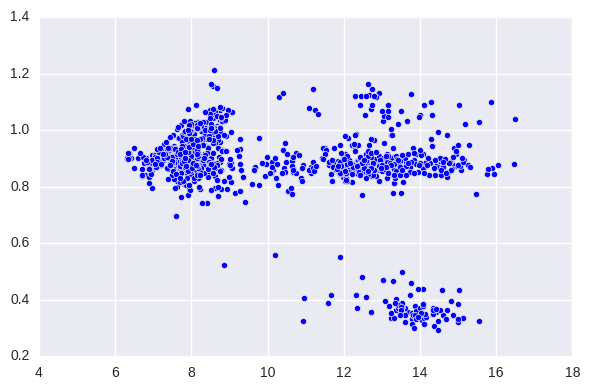

In [15]:
plt.scatter(cluster_averages[:,0], cluster_averages[:,2])

In [16]:
cluster_averages = pd.DataFrame(cluster_averages, columns=pnas_names)
active_clusters = cluster_averages.loc[(cluster_averages["rmsd_npxxy_active"] < 0.5) & (cluster_averages["tm6_tm3_dist"] > 12.) & (cluster_averages["tm6_tm3_dist"] < 15.)]
inactive_clusters = cluster_averages.loc[(cluster_averages["rmsd_npxxy_active"] > 0.5) & (cluster_averages["tm6_tm3_dist"] <10.)]

In [24]:
active_clusters

,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active


In [ ]:
plot_data_vs_data(np.concatenate(tica_coords), np.concatenate(pnas_coords), tica_names, pnas_names, analysis_dir)

In [ ]:
analysis_dir

In [ ]:
plot_columns(tica_dir, projected_features_dir, titles = ["tIC%d" %j for j in range(1,11)], tICA = True, scale = 1.0, refcoords_file = None)

In [57]:
from ipyparallel import Client
rc = Client()
print(len(rc.ids))
dview = rc[0:50]
dview.map(os.chdir, ['/home/enf/b2ar_analysis/conformation']*len(rc.ids))



234


<AsyncMapResult: chdir>

In [ ]:

indices = [0,1000]
chosen_receptors = []
for i in range(indices[0], indices[1]):
  for j in range(0, n_samples):
    chosen_receptors.append("cluster%d_sample%d" %(i, j))

biased_ligands = get_ligands(biased_agonist_dir)
print("biased_ligands")
print(biased_ligands)
reimaged_dir = save_dir
mae_dir = reimaged_dir
remove_ter(reimaged_dir)
reorder(reimaged_dir)

inverse_ligands = get_ligands(inverse_agonist_dir)
agonist_ligands = get_ligands(agonist_dir)

agonist_ligands = [a for a in agonist_ligands if "TA" not in a]

pprep(mae_dir, ref = active_ref_dir, chosen_receptors = chosen_receptors, worker_pool=dview)
generate_grids(mae_dir, grid_center, grid_dir, remove_lig = "BIA", chosen_receptors = chosen_receptors, worker_pool=dview)


dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)

dock_ligands_and_receptors(grid_dir, docking_dir,  biased_agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = biased_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)
dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)



In [ ]:

analyze_docking_results_multiple(docking_dir, precision = "SP", ligands = biased_ligands + agonist_ligands, summary = docking_multiple_ligands, redo = True)
compute_cluster_averages(None, csv_filename=docking_multiple_ligands, save_csv=aggregate_docking)

#compute_aggregate_scores(docking_multiple_ligands, inverse_agonists = inverse_ligands, summary = aggregate_docking, z_scores_csv = docking_z_scores_csv)
#aggregate_docking_joined_map = convert_csv_to_joined_map(aggregate_docking, aggregate_docking_joined)[0]
#aggregate_docking_means = calc_mean(aggregate_docking_joined_map)
#write_map_to_csv(aggregate_docking_joined, aggregate_docking_means, ["cluster", "mean_aggregate_docking_z_score"])
#r['do.analysis'](tica_dir, analysis_dir, pnas_coords_csv, tica_coords_csv, features_dir, docking_multiple_ligands)
tics_vs_docking_file = "%s/tICA_vs_docking.pdf" % analysis_dir
plot_tICs_vs_docking(docking_multiple_ligands, tica_coords_csv, tics_vs_docking_file, chosen_ligand="s-carvedilol")


In [ ]:
plot_timescales(clusterer_dir, n_clusters, tica_dir, list(range(1,25)))


In [15]:
grid_center = "64.4, 16.9, 11.99"

indices = [0,n_clusters]
chosen_receptors = []
for i in range(indices[0], indices[1]):
  for j in range(0, n_samples):
    chosen_receptors.append("cluster%d_sample%d" %(i, j))

biased_ligands = get_ligands(biased_agonist_dir)
print("biased_ligands")
print(biased_ligands)

#remove_ter(reimaged_dir)
#reorder(reimaged_dir)

inverse_ligands = get_ligands(inverse_agonist_dir)
agonist_ligands = get_ligands(agonist_dir)

agonist_ligands = [a for a in agonist_ligands if "TA" not in a and "ta" not in a]
print(agonist_ligands)
mehrdad_dir = "%s/mehrdad_ligands" %agonist_dir
mehrdad_ligands = get_ligands(mehrdad_dir, ".mol")

#pprep(mae_dir, ref = active_ref_dir, chosen_receptors = chosen_receptors, worker_pool=dview)
#generate_grids(mae_dir, grid_center, grid_dir, remove_lig = "BIA", chosen_receptors = chosen_receptors, worker_pool=dview)
#unzip_receptors(grid_dir, chosen_receptors, worker_pool=dview)

#dock_ligands_and_receptors(grid_dir, docking_dir,  biased_agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = biased_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)
#dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)

#dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)




biased_ligands
['', '', '', 'isoetharine', 'isoetharine_prepped', 'nebivolol', 's-carvedilol', 's-carvedilol_prepped', 'salmeterol', 'xamoterol']
['', '3p0g_lig', 'procaterol', 'r_epinephrine', 'r_isopreterenol', 'salmeterol']


In [384]:
mehrdad_ligands

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Carvedilol',
 'Compound_A',
 'Compound_B',
 'Compound_C',
 'Compound_D',
 'Compound_E',
 'Compound_F',
 'Compound_G',
 'Compound_H',
 'Compound_I',
 'Compound_J',
 'Xamoterol']

In [16]:
#docking_multiple_ligands = "%s/all_docking_scores.csv" % docking_dir
#aggregate_docking = "%s/aggregate_docking.csv" % docking_dir
print(biased_ligands + agonist_ligands)

analyze_docking_results_multiple(docking_dir, precision = "SP", ligands = biased_ligands + agonist_ligands + mehrdad_ligands + inverse_ligands, summary = docking_multiple_ligands, redo = True)
compute_cluster_averages(None, csv_filename=docking_multiple_ligands, save_csv=aggregate_docking)



['', '', '', 'isoetharine', 'isoetharine_prepped', 'nebivolol', 's-carvedilol', 's-carvedilol_prepped', 'salmeterol', 'xamoterol', '', '3p0g_lig', 'procaterol', 'r_epinephrine', 'r_isopreterenol', 'salmeterol']
Analyzing docking results
/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/docking_n_clusters1000_n_samples10_random_SP
['', '', '', 'isoetharine', 'isoetharine_prepped', 'nebivolol', 's-carvedilol', 's-carvedilol_prepped', 'salmeterol', 'xamoterol', '', '3p0g_lig', 'procaterol', 'r_epinephrine', 'r_isopreterenol', 'salmeterol', '', '', '', '', '', '', '', '', '', '', '', '', 'Carvedilol', 'Compound_A', 'Compound_B', 'Compound_C', 'Compound_D', 'Compound_E', 'Compound_F', 'Compound_G', 'Compound_H', 'Compound_I', 'Compound_J', 'Xamoterol', 's-atenolol', 's-carazolol']
/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0

,nebivolol,3p0g_lig,s-carazolol,xamoterol,s-carvedilol,isoetharine,r_isopreterenol,r_epinephrine,procaterol,s-atenolol
cluster0,9.349,10.141,8.447,8.208,8.814,7.461,7.662,7.584,8.730,6.070
cluster100,9.221,9.790,7.850,8.171,9.001,7.167,7.258,7.256,9.131,5.855
cluster101,8.903,9.503,7.904,8.043,9.011,7.021,7.026,6.946,7.994,5.875
cluster102,8.977,8.834,7.964,7.875,8.541,6.872,7.044,6.976,8.052,6.015
cluster103,10.605,10.414,8.368,9.001,9.802,7.468,7.296,7.240,8.879,6.686
cluster104,9.006,9.274,8.390,8.146,9.095,6.946,7.077,7.087,8.208,5.868
cluster105,8.774,8.313,7.725,7.686,8.703,6.014,6.087,6.425,7.851,5.529
cluster106,8.630,10.215,8.190,7.533,8.226,7.061,7.679,7.717,8.052,5.853
cluster107,8.979,10.779,7.579,7.775,8.259,7.321,7.538,7.134,9.530,5.942
cluster108,7.628,6.723,6.831,6.788,7.948,5.930,6.001,6.009,6.859,4.719


In [14]:
msm_model_dir = "%s/msm_lag_time10.h5" %tica_dir

In [13]:
df = pd.read_csv(docking_multiple_ligands, index_col=0, skip_blank_lines=True).dropna()
tica_coords_all = pd.read_csv(tica_coords_csv, index_col=0)
pnas_coords_all = pd.read_csv(pnas_coords_csv, index_col=0)
pnas_coords_all[" tm6_tm3_dist"] = pnas_coords_all[" tm6_tm3_dist"].values * 7.14
docking_tica = pd.concat([df, tica_coords_all, pnas_coords_all], axis=1, join='inner')

In [14]:
docking_tica.iloc[0:10]

,nebivolol,3p0g_lig,s-carazolol,xamoterol,s-carvedilol,isoetharine,r_isopreterenol,r_epinephrine,procaterol,s-atenolol,...,tIC_20,tIC_21,tIC_22,tIC_23,tIC_24,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active
sample,,,,,,,,,,,,,,,,,,,,,
cluster0_sample0,9.79,8.88,10.16,9.28,10.44,7.09,7.97,7.62,8.42,5.92,...,-5.665888,-43.529699,-43.323646,-55.562706,-60.639379,8.091405,0.402960,0.850420,0.331216,1.43767
cluster0_sample1,9.52,11.52,7.39,6.91,9.06,7.50,7.59,7.74,10.42,5.72,...,-1.779199,-33.847614,-36.195537,-53.356076,-54.818537,8.098902,0.516694,0.832236,0.157188,1.33231
cluster0_sample2,9.48,11.11,8.79,8.89,8.76,8.29,8.28,8.02,9.06,6.69,...,-13.905451,2.075456,-38.347554,-54.232471,-25.280429,8.592562,0.405541,0.856602,0.178418,1.34863
cluster0_sample3,8.31,8.42,7.44,7.58,7.16,6.12,5.66,5.56,7.63,6.20,...,-13.087966,17.607753,3.107066,-40.889019,-7.288385,6.593883,0.347635,0.920553,0.373171,1.48058
cluster0_sample4,8.47,10.32,8.39,8.95,7.92,7.14,8.17,7.94,8.81,6.69,...,-33.876194,-73.124296,-28.313617,-34.664568,1.981910,8.258552,0.496893,0.832403,0.311481,1.31650
cluster0_sample5,8.84,8.95,9.27,7.18,9.11,7.52,7.17,6.85,8.95,5.41,...,10.775007,-23.807138,-28.751754,-31.018728,0.141239,8.250841,0.502724,0.694240,0.289400,1.58653
cluster0_sample6,9.15,11.53,8.46,8.94,8.13,8.21,8.82,8.53,9.25,5.75,...,-17.917153,-50.343985,-49.000224,-41.430448,-43.429722,7.713913,0.404817,0.815610,0.582680,1.28353
cluster0_sample7,10.44,10.16,8.02,7.82,8.83,6.37,7.10,6.68,8.63,4.55,...,9.187813,30.023958,-46.927048,17.025044,-36.868398,6.372279,0.392163,0.901219,0.305946,1.53605
cluster0_sample8,10.25,10.77,8.12,8.34,9.97,7.74,7.55,8.40,9.31,7.80,...,-26.899352,-57.324011,-33.075042,-62.108766,-7.041988,8.459401,0.430251,0.948237,0.182208,1.47371


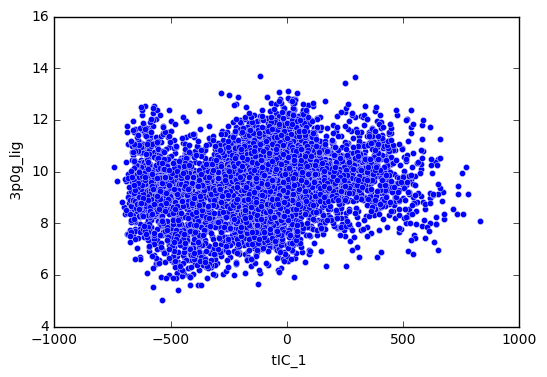

In [15]:
docking_tica.loc[docking_tica[" tm6_tm3_dist"] < 12.].plot(x=" tIC_1", y=" 3p0g_lig", kind='scatter')

we are operating on biox3


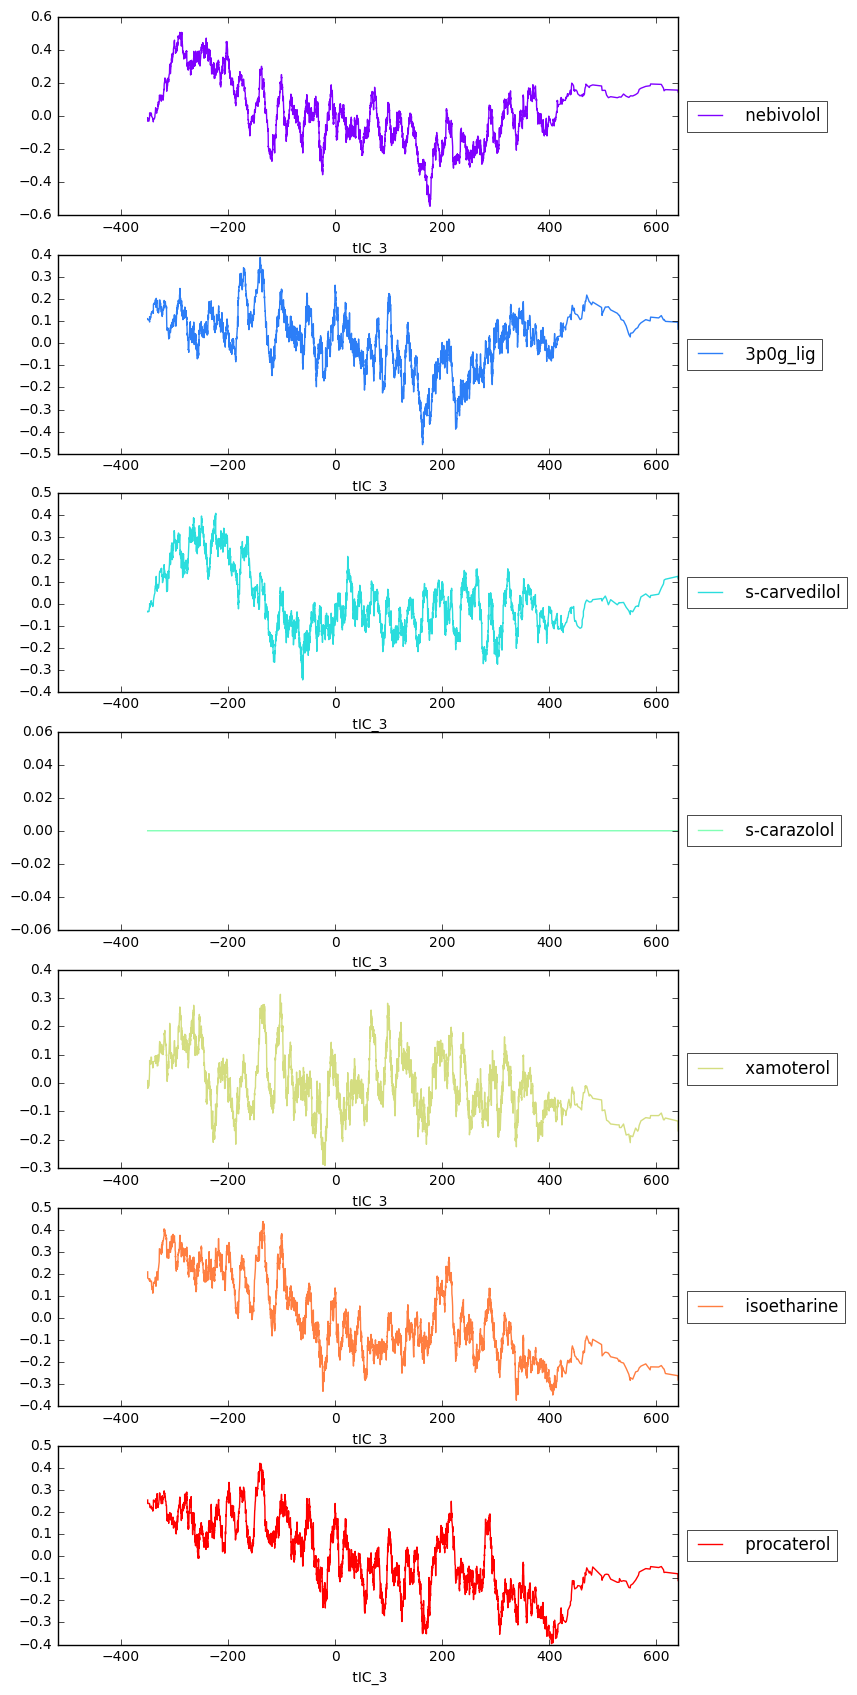

In [104]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
from sklearn.preprocessing import scale
tic = " tIC_3"
docking_tica = docking_tica.sort(tic, ascending=True)
plot_df = docking_tica.loc[docking_tica[" tm6_tm3_dist"] < 12.][[" nebivolol", " 3p0g_lig", " s-carvedilol", " s-carazolol", " xamoterol", " isoetharine", " procaterol"]]
plot_df = plot_df.subtract(plot_df[" s-carazolol"], axis=0)
plot_df[plot_df.columns.values] = scale(plot_df.values)
plot_df.iloc[0:10]
plot_df.index = docking_tica.loc[docking_tica[" tm6_tm3_dist"] < 12.][tic]

plot_df_rolling(plot_df, "/home/enf/test.pdf", return_fig=True, subplots=True, smoothing=100, include_original=False)
plot_df = pd.concat([plot_df, tica_coords_all, pnas_coords_all], axis=1, join='inner')

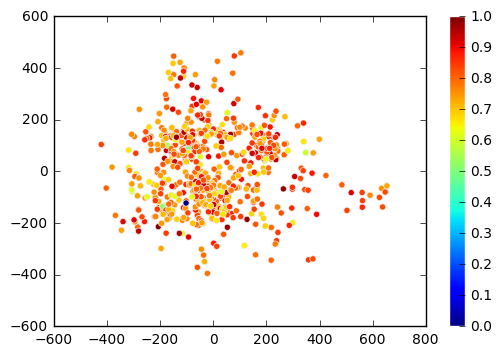

In [87]:
from sklearn import preprocessing
from matplotlib.mlab import griddata
plt.clf()
#fig = plt.figure(figsize=(6,6))
#ax = fig.add_subplot(111)
z=preprocessing.MinMaxScaler().fit_transform(plot_df[" nebivolol"].values[::10])
#vmin = np.min(c)
#vmax = np.max(c)
#plt.pcolor(plot_df[" tIC_4"].values, plot_df[" tIC_5"].values, c[-1], cmap='RdBu')#, marker = 'o', cmap = cm.jet, vmin=vmin, vmax=vmax );
y = plot_df[" tIC_5"].values[::10]
x = plot_df[" tIC_4"].values[::10]

plt.scatter(x, y, c=z, s=20, vmax = z.max(), vmin = z.min()) # s=120 implies a marker size of 12 points.
plt.colorbar()

In [82]:
plot_df[" nebivolol"].values.min()

-12.052195054026447

In [ ]:
docking_tica.loc[docking_tica[" tm6_tm3_dist"] < 12.].plot(x=" tIC_1", y=" nebivolol", kind='scatter')

In [22]:
df_agg = pd.read_csv(aggregate_docking, index_col=0, skip_blank_lines=True).dropna()
df_agg = df_agg[np.isfinite(df_agg[" 3p0g_lig"])]
print(df_agg.shape)

msm_obj = verboseload(msm_model_dir)

msm_clusters = msm_obj.mapping_.keys()
msm_cluster_names = ["cluster%d" %i for i in msm_clusters]
aggregate_docking_msm = df_agg.loc[msm_cluster_names]
aggregate_docking_msm = aggregate_docking_msm[np.isfinite(aggregate_docking_msm[" 3p0g_lig"])]
msm_cluster_names = aggregate_docking_msm.index.values
msm_clusters = [i for i in msm_clusters if "cluster%d" %i in msm_cluster_names]
print(aggregate_docking_msm.shape)



msm_cluster_eq_pops = []
for cluster_id in msm_clusters:
    state_id = msm_obj.mapping_[cluster_id]
    msm_cluster_eq_pops.append(msm_obj.populations_[state_id])
msm_cluster_eq_pops = np.array(msm_cluster_eq_pops)
msm_cluster_deltaG = -0.61 * np.log(msm_cluster_eq_pops)
msm_cluster_eq_pops_df = pd.DataFrame(msm_cluster_eq_pops, index=msm_cluster_names)

(987, 10)
loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/msm_lag_time10.h5"...
(980, 10)


In [23]:
len(msm_cluster_names)

980

In [24]:
pnas_cluster_averages = calculate_cluster_averages_per_feature(verboseload(clusterer_dir), verboseload(pnas_coords_dir))
pnas_cluster_averages_msm = pnas_cluster_averages[msm_clusters,:]
tica_cluster_averages = calculate_cluster_averages_per_feature(verboseload(clusterer_dir), verboseload(projected_features_dir))
tica_cluster_averages_msm = tica_cluster_averages[msm_clusters,:]
tic_names = ["tIC.%d" %i for i in range(1, n_components+1)]
tica_cluster_averages_df = pd.DataFrame(tica_cluster_averages_msm, columns=tic_names, index=msm_cluster_names)
pnas_cluster_averages_df = pd.DataFrame(pnas_cluster_averages_msm, columns=pnas_titles, index=msm_cluster_names)
pnas_cluster_averages_df["tm6_tm3_dist"] = pnas_cluster_averages_df["tm6_tm3_dist"]*7.14

loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_1000clusters.h5"...
loading "/home/enf/b2ar_analysis/all_pnas_features/pnas_coords.h5"...
loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_1000clusters.h5"...
loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/phi_psi_chi2_allprot_projected.h5"...


In [25]:
df_agg.columns.values

array([' nebivolol', ' 3p0g_lig', ' s-carazolol', ' xamoterol',
       ' s-carvedilol', ' isoetharine', ' r_isopreterenol',
       ' r_epinephrine', ' procaterol', ' s-atenolol '], dtype=object)

In [26]:
train_gprot_agonists = [a for a in df_agg.columns.values if "procaterol" in a]
biased_antagonists = [a for a in df_agg.columns.values if "s-carvedilol" in a]
train_inverse_agonists = [a for a in df_agg.columns.values if "carazolol" in a]
#agonists = [a for a in df_agg.columns.values if a not in biased_antagonists and "salmeterol" not in a]
train_agonists = [a for a in df_agg.columns.values if "procaterol" in a]
train_biased_antagonists = [a for a in df_agg.columns.values if "carvedilol" in a]
train_arrestin_agonists = [a for a in df_agg.columns.values if " isoetharine" in a]
only_3p0g = [" 3p0g_lig"]
biased_ligands = biased_antagonists + only_3p0g



In [27]:
print(len(msm_cluster_deltaG))

980


NameError: name 'ligand' is not defined

In [28]:
aggregate_docking_msm = aggregate_docking_msm[np.isfinite(aggregate_docking_msm[" s-carvedilol"])]
new_populations = copy.deepcopy(aggregate_docking_msm)
for ligand in aggregate_docking_msm.columns.values:
    new_populations[ligand] = np.exp(-1.0*(-1.0*aggregate_docking_msm[ligand].values+msm_cluster_deltaG)/0.61)
Z = np.sum(new_populations.values, axis=0)
print(Z)
for j, ligand in enumerate(aggregate_docking_msm.columns.values):
    new_populations[ligand] = new_populations[ligand].values / Z[j]
population_deltas = copy.deepcopy(new_populations)
for ligand in aggregate_docking_msm.columns.values:
    population_deltas[ligand] = population_deltas[ligand].values / msm_cluster_eq_pops
new_energies = copy.deepcopy(new_populations)
for ligand in aggregate_docking_msm.columns.values:
    new_energies[ligand] = -.61 * np.log(new_populations[ligand])
delta_delta_g = copy.deepcopy(new_energies)
for ligand in aggregate_docking_msm.columns.values:
    delta_delta_g[ligand] = (new_energies[ligand].values - msm_cluster_deltaG)
    

[  1.40992150e+07   3.16777604e+07   6.83573527e+05   1.60105724e+06
   4.47073730e+06   1.27980749e+05   1.49817240e+05   1.67212814e+05
   1.17064738e+06   1.36304840e+04]


In [29]:
docking_tica_msm = pd.concat([aggregate_docking_msm, tica_cluster_averages_df, pnas_cluster_averages_df], axis=1).sort(" s-carvedilol", ascending=False)
docking_tica_msm.sort(" s-carvedilol", ascending=False).iloc[0:10]

,nebivolol,3p0g_lig,s-carazolol,xamoterol,s-carvedilol,isoetharine,r_isopreterenol,r_epinephrine,procaterol,s-atenolol,...,tIC.21,tIC.22,tIC.23,tIC.24,tIC.25,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active
cluster524,10.796,10.896,9.446,9.410,10.995,7.793,7.755,7.377,8.897,7.001,...,28.450553,-40.008243,51.885080,8.855290,-49.992270,7.909546,0.505464,0.939694,0.413896,1.488253
cluster124,10.345,11.439,9.559,8.986,10.891,7.152,7.606,7.384,9.902,6.751,...,3.150581,16.784529,-40.938491,-77.633078,-12.318499,8.629811,0.563698,1.065535,0.393252,1.531304
cluster596,11.035,10.858,9.517,9.575,10.878,7.446,7.646,7.541,8.878,7.427,...,23.681758,-44.567668,-30.902177,-70.395756,-35.415760,8.252684,0.569333,1.014400,0.409534,1.548464
cluster48,10.730,10.402,9.376,8.883,10.842,7.522,7.585,7.401,8.730,6.565,...,10.103049,-39.689702,-26.363491,-59.233646,-32.712071,8.238292,0.576229,1.004615,0.434604,1.556658
cluster201,10.892,11.375,9.610,9.097,10.828,7.714,7.775,7.500,9.234,6.915,...,-12.768430,20.905878,-35.016446,-78.750123,-24.002164,8.539602,0.542787,1.008996,0.437729,1.551804
cluster618,10.895,11.549,9.746,9.323,10.764,7.508,7.924,7.743,9.047,6.942,...,-7.747605,14.725959,-31.795981,-101.516344,-44.003772,8.751533,0.550531,1.009686,0.415275,1.534190
cluster794,10.026,10.299,9.791,8.747,10.697,7.632,8.069,7.952,9.131,7.658,...,-18.592199,35.187897,97.914036,-9.698319,-9.414799,11.895254,0.439892,0.843733,0.291835,1.486054
cluster802,10.380,10.649,9.328,9.206,10.624,7.392,7.493,7.179,9.043,7.314,...,27.867168,-49.096149,2.257831,0.217978,-55.842844,8.523606,0.645477,1.019114,0.404602,1.549154
cluster439,10.244,10.382,9.230,8.981,10.612,7.392,7.310,7.107,8.476,6.663,...,6.655712,-61.999513,32.112906,-3.890956,23.014426,8.803522,0.660569,1.032237,0.415026,1.556555
cluster859,10.356,10.264,8.957,8.698,10.498,7.932,7.964,7.720,8.918,6.537,...,3.547230,-29.591970,-5.911438,9.704810,19.954218,8.576571,0.602830,0.849560,0.301702,1.480254


In [30]:
deltas_tica = pd.concat([delta_delta_g, tica_cluster_averages_df, pnas_cluster_averages_df], axis=1).sort(" s-carvedilol", ascending=True)
deltas_tica.iloc[0:10]

,nebivolol,3p0g_lig,s-carazolol,xamoterol,s-carvedilol,isoetharine,r_isopreterenol,r_epinephrine,procaterol,s-atenolol,...,tIC.21,tIC.22,tIC.23,tIC.24,tIC.25,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active
cluster524,-0.754406,-0.360613,-1.250595,-0.695433,-1.654031,-0.619623,-0.485525,-0.040516,-0.373429,-1.193761,...,28.450553,-40.008243,51.885080,8.855290,-49.992270,7.909546,0.505464,0.939694,0.413896,1.488253
cluster124,-0.303406,-0.903613,-1.363595,-0.271433,-1.550031,0.021377,-0.336525,-0.047516,-1.378429,-0.943761,...,3.150581,16.784529,-40.938491,-77.633078,-12.318499,8.629811,0.563698,1.065535,0.393252,1.531304
cluster596,-0.993406,-0.322613,-1.321595,-0.860433,-1.537031,-0.272623,-0.376525,-0.204516,-0.354429,-1.619761,...,23.681758,-44.567668,-30.902177,-70.395756,-35.415760,8.252684,0.569333,1.014400,0.409534,1.548464
cluster48,-0.688406,0.133387,-1.180595,-0.168433,-1.501031,-0.348623,-0.315525,-0.064516,-0.206429,-0.757761,...,10.103049,-39.689702,-26.363491,-59.233646,-32.712071,8.238292,0.576229,1.004615,0.434604,1.556658
cluster201,-0.850406,-0.839613,-1.414595,-0.382433,-1.487031,-0.540623,-0.505525,-0.163516,-0.710429,-1.107761,...,-12.768430,20.905878,-35.016446,-78.750123,-24.002164,8.539602,0.542787,1.008996,0.437729,1.551804
cluster618,-0.853406,-1.013613,-1.550595,-0.608433,-1.423031,-0.334623,-0.654525,-0.406516,-0.523429,-1.134761,...,-7.747605,14.725959,-31.795981,-101.516344,-44.003772,8.751533,0.550531,1.009686,0.415275,1.534190
cluster794,0.015594,0.236387,-1.595595,-0.032433,-1.356031,-0.458623,-0.799525,-0.615516,-0.607429,-1.850761,...,-18.592199,35.187897,97.914036,-9.698319,-9.414799,11.895254,0.439892,0.843733,0.291835,1.486054
cluster802,-0.338406,-0.113613,-1.132595,-0.491433,-1.283031,-0.218623,-0.223525,0.157484,-0.519429,-1.506761,...,27.867168,-49.096149,2.257831,0.217978,-55.842844,8.523606,0.645477,1.019114,0.404602,1.549154
cluster439,-0.202406,0.153387,-1.034595,-0.266433,-1.271031,-0.218623,-0.040525,0.229484,0.047571,-0.855761,...,6.655712,-61.999513,32.112906,-3.890956,23.014426,8.803522,0.660569,1.032237,0.415026,1.556555
cluster859,-0.314406,0.271387,-0.761595,0.016567,-1.157031,-0.758623,-0.694525,-0.383516,-0.394429,-0.729761,...,3.547230,-29.591970,-5.911438,9.704810,19.954218,8.576571,0.602830,0.849560,0.301702,1.480254


In [31]:
procaterol = [lig for lig in deltas_tica.columns.values if "procaterol" in lig][0]

In [32]:
deltas_tica["neb_div_carv"] = deltas_tica[" nebivolol"].subtract(deltas_tica[" s-carvedilol"])
deltas_tica["neb_div_cara"] = deltas_tica[" nebivolol"].subtract(deltas_tica[" s-carazolol"])
deltas_tica["3p0g_div_cara"] = deltas_tica[" 3p0g_lig"].subtract(deltas_tica[" s-carazolol"])
deltas_tica["carv_div_cara"] = deltas_tica[" s-carvedilol"].subtract(deltas_tica[" s-carazolol"])

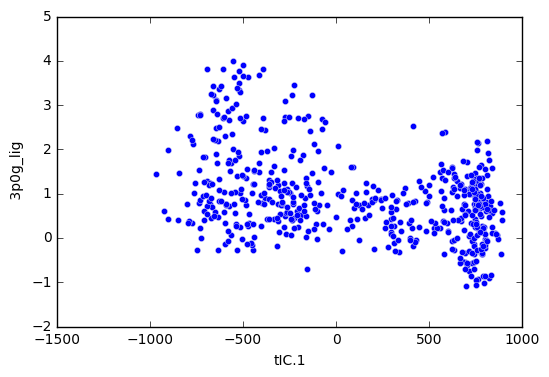

In [33]:
deltas_tica.loc[deltas_tica["tm6_tm3_dist"] < 12.].plot(x="tIC.1", y=" 3p0g_lig", kind='scatter')

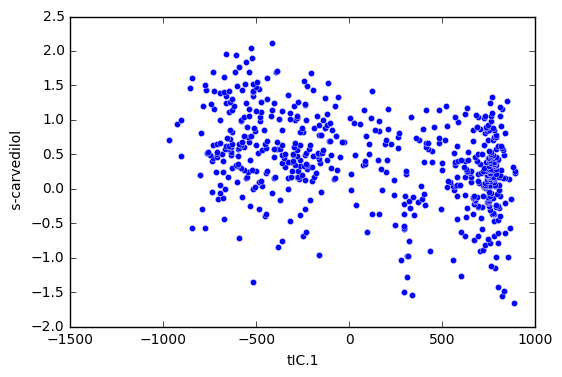

In [202]:
deltas_tica.loc[deltas_tica["tm6_tm3_dist"] < 12.].plot(x="tIC.1", y=" s-carvedilol", kind='scatter')

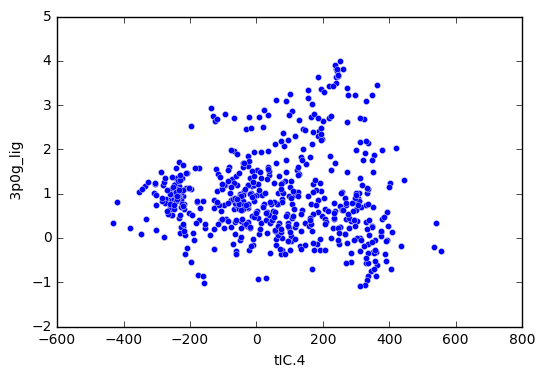

In [203]:
deltas_tica.loc[deltas_tica["tm6_tm3_dist"] < 12.].plot(x="tIC.4", y=" 3p0g_lig", kind='scatter')

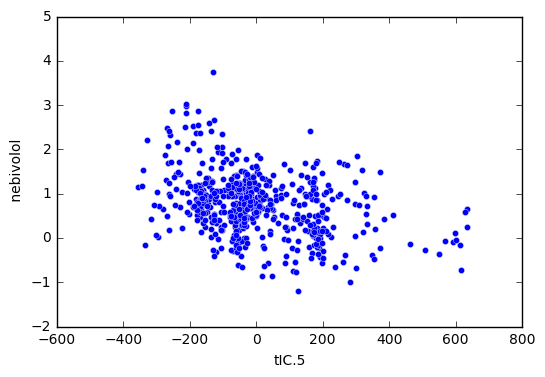

In [204]:
deltas_tica.loc[deltas_tica["tm6_tm3_dist"] < 12.].plot(x="tIC.5", y=" nebivolol", kind='scatter')

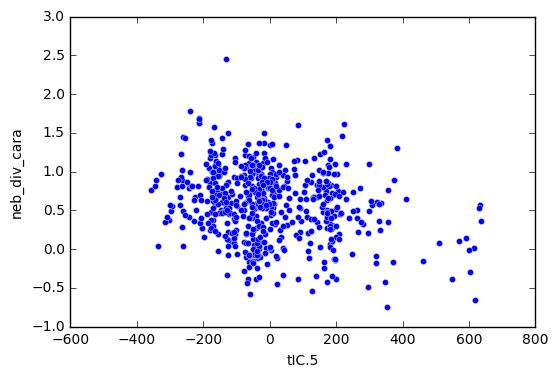

In [236]:
deltas_tica.loc[deltas_tica["tm6_tm3_dist"] < 12.].plot(x = "tIC.5", y = "neb_div_cara", kind='scatter')

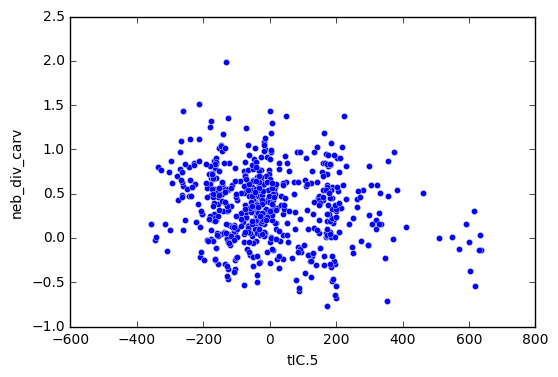

In [237]:
deltas_tica.loc[deltas_tica["tm6_tm3_dist"] < 12.].plot(x = "tIC.5", y = "neb_div_carv", kind='scatter')

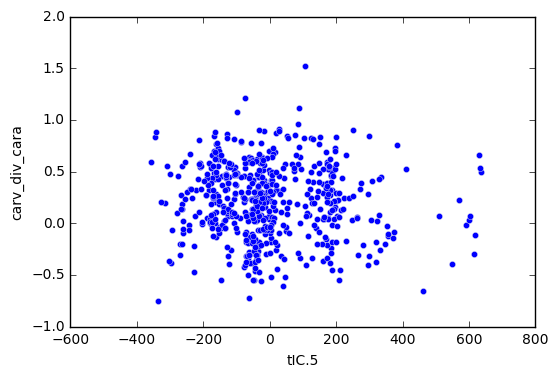

In [243]:
deltas_tica.loc[deltas_tica["tm6_tm3_dist"] < 12.].plot(x = "tIC.5", y = "carv_div_cara", kind='scatter')

In [241]:
from scipy.stats import pearsonr
for name in ["tIC.%d" %i for i in range(1,n_components+1)]:
    print(pearsonr(deltas_tica[name].values, deltas_tica["carv_div_cara"].values))

(-0.14532394609340332, 4.9281757203630329e-06)
(0.060068187695465361, 0.060144975957815948)
(-0.17512251669200299, 3.4307611550046636e-08)
(0.061404415204658142, 0.05465327949178541)
(-0.083954948367682858, 0.0085511854200737356)
(0.043498148357932198, 0.17363584670082777)
(-0.036018751589222221, 0.25995743251012282)
(-0.0034921842595145519, 0.91305697225018523)
(-0.051121757967646904, 0.10973896245950505)
(-0.04558180226100586, 0.15390987919840515)
(-0.061385222229269398, 0.054729098331653382)
(0.15345412655017227, 1.3905380082720078e-06)
(0.18180214430102273, 9.9326351362348484e-09)
(-0.025623254878657097, 0.42299122833925529)
(-0.016765635045106801, 0.60012942828655125)
(-0.0590312558594807, 0.064714805786997676)
(0.11795775677057492, 0.00021485616123332994)
(0.024564548585094739, 0.44241204717301674)
(0.079360325904193479, 0.012950745297039955)
(-0.1447415773616329, 5.3819113263843445e-06)
(0.041299478499879458, 0.19643359207114999)
(0.10456116948295584, 0.0010451051641492827)
(0.0

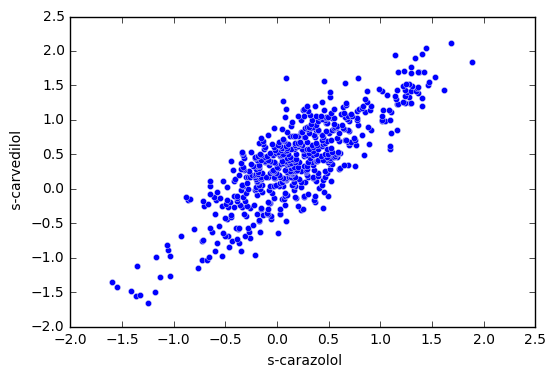

In [207]:
deltas_tica.loc[deltas_tica["tm6_tm3_dist"] < 12.].plot(x=" s-carazolol", y=" s-carvedilol", kind='scatter')

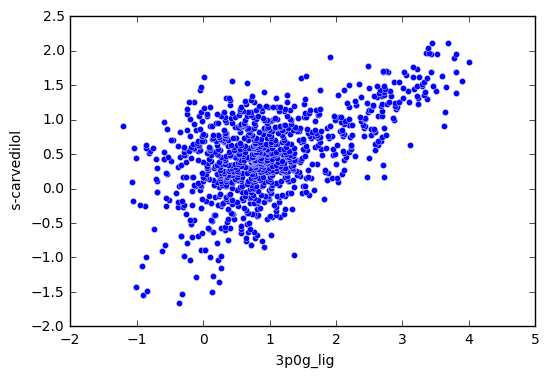

In [208]:
deltas_tica.loc[deltas_tica["tm6_tm3_dist"] < 16.].plot(x=" 3p0g_lig", y=" s-carvedilol", kind='scatter')

In [222]:
print(biased_antagonists)
print(train_inverse_agonists)
#agonist_states = deltas_tica.loc[(deltas_tica[agonists].min(axis=1) > deltas_tica[biased_antagonists + inverse_agonists].max(axis=1)) & (deltas_tica[agonists].min(axis=1) > 1.0)]
from sklearn.preprocessing import scale
docking_normalized = copy.deepcopy(population_deltas)
docking_normalized[docking_normalized.columns.values] = scale(population_deltas.values)

agonist_minus_antagonists = deltas_tica[train_agonists].mean(axis=1).values - deltas_tica[train_inverse_agonists + train_biased_antagonists].mean(axis=1).values
agonist_minus_antagonists = (agonist_minus_antagonists - np.mean(agonist_minus_antagonists))/np.std(agonist_minus_antagonists)
agonist_states = deltas_tica.iloc[np.where(agonist_minus_antagonists > 2.0)].loc[docking_normalized[train_agonists].min(axis=1) > 1.]

bias_antagonist_minus_antagonists = deltas_tica[[" nebivolol"]].mean(axis=1).values - deltas_tica[train_inverse_agonists].mean(axis=1).values
bias_antagonist_minus_antagonists = scale(bias_antagonist_minus_antagonists)

bias_antagonist_minus_agonists = deltas_tica[[" 3p0g_lig"]].mean(axis=1).values - deltas_tica[train_agonists].mean(axis=1).values
bias_antagonist_minus_agonists = scale(bias_antagonist_minus_agonists)
indices = list(set(np.where(bias_antagonist_minus_antagonists < -2.)[0].tolist()))#.intersection(set(np.where(bias_antagonist_minus_agonists > 1.)[0].tolist())))
biased_antagonist_states = deltas_tica.iloc[indices].loc[deltas_tica[[" nebivolol"]].min(axis=1) <0.]
print(biased_antagonist_states)


gprot_agonists_minus_arrestin_agonists = deltas_tica[train_gprot_agonists].mean(axis=1).values - deltas_tica[train_arrestin_agonists].mean(axis=1).values
gprot_agonists_minus_arrestin_agonists = (gprot_agonists_minus_arrestin_agonists - np.mean(gprot_agonists_minus_arrestin_agonists))/np.std(gprot_agonists_minus_arrestin_agonists)
gprot_agonist_states = deltas_tica.iloc[np.where(gprot_agonists_minus_arrestin_agonists > 1.)].loc[docking_normalized[train_gprot_agonists].min(axis=1) > 1.]

arrestin_agonist_states = deltas_tica.iloc[np.where(gprot_agonists_minus_arrestin_agonists < -1.)].loc[docking_normalized[train_arrestin_agonists].min(axis=1) > 1.]


#gprot_agonist_states = deltas_tica.loc[(deltas_tica[gprot_agonists].min(axis=1) > deltas_tica[biased_antagonists].max(axis=1)) & (deltas_tica[gprot_agonists].min(axis=1) > 1.0)]
#biased_antagonist_states = deltas_tica.loc[(deltas_tica[biased_antagonists].min(axis=1) > deltas_tica[agonists + inverse_agonists].max(axis=1)) & (deltas_tica[biased_antagonists].min(axis=1) > 1.0)]
#biased_ligand_states = deltas_tica.loc[(deltas_tica[biased_ligands].min(axis=1) > deltas_tica[gprot_agonists].max(axis=1)) & (deltas_tica[biased_ligands].min(axis=1) > 1.0)]

[' s-carvedilol']
[' s-carazolol']
             nebivolol   3p0g_lig   s-carazolol   xamoterol   s-carvedilol  \
cluster115   -0.312406   0.181387      0.262405    0.356567      -0.124031   
cluster656   -1.192406   0.103387     -0.656595   -0.571433      -0.992031   
cluster401   -0.454406  -0.560613     -0.069595   -0.016433       0.226969   
cluster953   -0.664406   0.764387     -0.273595    0.222567      -0.630031   
cluster154   -0.217406   0.234387      0.237405    0.500567       0.025969   
cluster103   -0.563406   0.121387     -0.172595   -0.286433      -0.461031   
cluster701   -0.465406   0.315387      0.278405   -0.204433       0.250969   
cluster551   -0.029406  -0.525613      0.323405    0.535567       0.451969   
cluster432   -0.359406  -0.263613      0.031405   -0.129433      -0.368031   
cluster797   -0.157406   1.072387      0.073405    0.022567      -0.233031   
cluster922   -0.041406   0.186387      0.260405    0.006567       0.326969   
cluster705   -0.734406  -0.37

In [35]:
#agonist_states = deltas_tica.loc[(deltas_tica[agonists].min(axis=1) > deltas_tica[biased_antagonists + inverse_agonists].max(axis=1)) & (deltas_tica[agonists].min(axis=1) > 1.0)]
from sklearn.preprocessing import scale
train_biased_antagonists = [" s-carvedilol", " nebivolol", " 3p0g_lig"]
docking_normalized = copy.deepcopy(population_deltas)
docking_normalized[docking_normalized.columns.values] = scale(population_deltas.values)

agonist_minus_antagonists = deltas_tica[train_agonists].mean(axis=1).values - deltas_tica[train_inverse_agonists + train_biased_antagonists].mean(axis=1).values
agonist_minus_antagonists = (agonist_minus_antagonists - np.mean(agonist_minus_antagonists))/np.std(agonist_minus_antagonists)
agonist_states = deltas_tica.iloc[np.where(agonist_minus_antagonists > 2.0)].loc[docking_normalized[train_agonists].min(axis=1) > 1.]

bias_antagonist_minus_antagonists = deltas_tica[train_biased_antagonists].mean(axis=1).values - deltas_tica[train_inverse_agonists].mean(axis=1).values
bias_antagonist_minus_antagonists = scale(bias_antagonist_minus_antagonists)

bias_antagonist_minus_agonists = deltas_tica[[" 3p0g_lig"]].mean(axis=1).values - deltas_tica[train_agonists].mean(axis=1).values
bias_antagonist_minus_agonists = scale(bias_antagonist_minus_agonists)
indices = list(set(np.where(bias_antagonist_minus_antagonists < -1.)[0]))#.tolist()).intersection(set(np.where(bias_antagonist_minus_antagonists > 1.)[0].tolist())))
print(np.where(scale(deltas_tica[train_biased_antagonists].mean(axis=1).values) < -.5)[0])
biased_antagonist_states = deltas_tica.iloc[list(set(indices).intersection(set(np.where(scale(deltas_tica[train_biased_antagonists].mean(axis=1).values) < -1.)[0])))]
print(biased_antagonist_states)




[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  65  66  67  69  70  71  72  73
  74  75  77  78  79  80  81  82  83  84  85  86  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 111 112 113
 114 116 117 118 120 121 122 123 124 125 126 127 129 130 131 133 134 135
 137 138 139 140 141 143 144 146 147 148 149 150 153 154 155 156 161 162
 163 164 165 166 168 169 170 171 172 178 181 183 184 185 186 188 190 192
 195 198 199 201 202 203 204 206 208 209 211 212 213 214 216 217 218 222
 224 228 229 230 233 235 237 238 241 242 246 248 249 250 251 254 256 259
 264 265 266 268 275 278 280 281 284 286 288 291 293 294 295 300 309 310
 312 326 327 331 337 338 340 342 343 344 351 357 358 360 365 372 373 377
 382 397 400 405 409 415 421 428 434 438 439 440 44

In [36]:
agonist_population = new_populations.loc[agonist_states.index].sum(axis=0)
agonist_ori = msm_cluster_eq_pops_df.loc[agonist_states.index].sum().values[0]
agonist_change = agonist_population.divide(agonist_ori)


biased_population = new_populations.loc[biased_antagonist_states.index].sum(axis=0)
biased_antagonist_ori = msm_cluster_eq_pops_df.loc[biased_antagonist_states.index].sum().values[0]
biased_antagonist_change = biased_population.divide(biased_antagonist_ori)



#gprot_population = new_populations.loc[gprot_agonist_states.index].sum(axis=0)
#gprot_ori = msm_cluster_eq_pops_df.loc[gprot_agonist_states.index].sum().values[0]
#gprot_change = gprot_population.divide(gprot_ori)



#arrestin_agonist_population = new_populations.loc[arrestin_agonist_states.index].sum(axis=0)
#arrestin_agonist_ori = msm_cluster_eq_pops_df.loc[arrestin_agonist_states.index].sum().values[0]
#arrestin_agonist_change = arrestin_agonist_population.divide(arrestin_agonist_ori)

#biased_vs_agonist_state_change = biased_antagonist_change.divide(agonist_change)
#biased_vs_agonist_state_change /= biased_vs_agonist_state_change[" r_isopreterenol"]

#biased_antagonist_vs_gprot_agonist_state_change = biased_antagonist_change.divide(gprot_change)
#biased_antagonist_vs_gprot_agonist_state_change /= biased_antagonist_vs_gprot_agonist_state_change[" r_isopreterenol"]

print("Agonist state changes:")
print(agonist_change)
print("Arrestin antagonist state  changes:")
print(biased_antagonist_change)
print(type(biased_antagonist_change))
biased_antagonist_change.sort()
print(biased_antagonist_change)
#print("Gprot agonist state changes:")
#print(gprot_change)
#print("Arrestin agonist state changes:")
##print(arrestin_agonist_change)
#print("Biased antagonist state change vs. Agonist state change")
#print(biased_vs_agonist_state_change)
#print("Biased antagonist vs Gprot agonist state change")
#print(biased_antagonist_vs_gprot_agonist_state_change)



Agonist state changes:
 nebivolol         NaN
 3p0g_lig          NaN
 s-carazolol       NaN
 xamoterol         NaN
 s-carvedilol      NaN
 isoetharine       NaN
 r_isopreterenol   NaN
 r_epinephrine     NaN
 procaterol        NaN
 s-atenolol        NaN
dtype: float64
Arrestin antagonist state  changes:
 nebivolol          1.227579
 3p0g_lig           1.270373
 s-carazolol        1.145813
 xamoterol          1.126845
 s-carvedilol       1.396059
 isoetharine        1.098609
 r_isopreterenol    1.091583
 r_epinephrine      1.125331
 procaterol         1.157254
 s-atenolol         0.795455
dtype: float64
<class 'pandas.core.series.Series'>
 s-atenolol         0.795455
 r_isopreterenol    1.091583
 isoetharine        1.098609
 r_epinephrine      1.125331
 xamoterol          1.126845
 s-carazolol        1.145813
 procaterol         1.157254
 nebivolol          1.227579
 3p0g_lig           1.270373
 s-carvedilol       1.396059
dtype: float64


In [189]:
pd.set_option('display.max_columns', None)

In [244]:
deltas_tica.loc[agonist_states.index]

,nebivolol,3p0g_lig,s-carazolol,xamoterol,s-carvedilol,isoetharine,r_isopreterenol,r_epinephrine,procaterol,s-atenolol,tIC.1,tIC.2,tIC.3,tIC.4,tIC.5,tIC.6,tIC.7,tIC.8,tIC.9,tIC.10,tIC.11,tIC.12,tIC.13,tIC.14,tIC.15,tIC.16,tIC.17,tIC.18,tIC.19,tIC.20,tIC.21,tIC.22,tIC.23,tIC.24,tIC.25,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active,neb_div_cara,3p0g_div_cara,carv_div_cara,neb_div_carv


In [245]:
deltas_tica.loc[biased_antagonist_states.index]

,nebivolol,3p0g_lig,s-carazolol,xamoterol,s-carvedilol,isoetharine,r_isopreterenol,r_epinephrine,procaterol,s-atenolol,tIC.1,tIC.2,tIC.3,tIC.4,tIC.5,tIC.6,tIC.7,tIC.8,tIC.9,tIC.10,tIC.11,tIC.12,tIC.13,tIC.14,tIC.15,tIC.16,tIC.17,tIC.18,tIC.19,tIC.20,tIC.21,tIC.22,tIC.23,tIC.24,tIC.25,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active,neb_div_cara,3p0g_div_cara,carv_div_cara,neb_div_carv
cluster115,-0.312406,0.181387,0.262405,0.356567,-0.124031,-0.427623,-0.115525,0.508484,-0.110429,-0.025761,687.982561,-97.448873,24.595638,-302.883414,-59.543697,-35.301641,28.471320,-30.113109,-43.984418,-35.838510,-14.180931,-86.413185,-201.677019,-16.874575,219.703835,86.837688,-13.079133,-12.434565,-39.822445,-3.915484,26.090395,7.311167,-10.493184,-27.706004,-29.322527,8.479342,0.788745,1.071073,0.344084,1.372410,-0.57481,-0.081018,-0.386436,-0.188375
cluster656,-1.192406,0.103387,-0.656595,-0.571433,-0.992031,0.050377,0.021475,0.132484,0.052571,-0.878761,855.285693,-56.180650,4.526761,-231.319953,126.084541,-7.201954,-18.689861,463.683433,19.444313,207.515546,-102.378196,-3.434886,-220.589716,-26.531210,-168.018560,53.483697,67.243169,13.915542,11.796545,-8.577558,73.582127,-74.386319,5.414252,0.682844,10.745398,8.773542,0.668876,1.042905,0.393647,1.618747,-0.53581,0.759982,-0.335436,-0.200375
cluster401,-0.454406,-0.560613,-0.069595,-0.016433,0.226969,-0.716623,-0.477525,-0.384516,-0.561429,-0.502761,706.013200,69.677751,-76.765210,269.926478,200.147287,69.376159,-218.338703,-22.604787,6.149526,16.441787,-48.141521,50.297041,38.793147,14.482672,205.339615,19.942222,92.645070,5.219710,-83.014203,9.037342,53.115389,-4.844349,2.537758,-41.278077,22.482557,8.252937,0.568431,0.958701,0.348849,1.473241,-0.38481,-0.491018,0.296564,-0.681375
cluster953,-0.664406,0.764387,-0.273595,0.222567,-0.630031,0.004377,0.060475,-0.144516,-0.086429,-0.116761,-230.070148,-75.323138,525.537893,-119.439649,-42.616268,154.613943,-103.087831,-12.432158,-15.095920,-44.352192,-157.856629,-26.000077,13.228914,1.666852,-142.381060,8.704249,34.466712,-31.889762,-121.026333,35.685235,25.254375,-41.255947,-51.353347,44.470642,-36.756880,10.469534,0.426318,0.852418,1.785445,1.191709,-0.39081,1.037982,-0.356436,-0.034375
cluster154,-0.217406,0.234387,0.237405,0.500567,0.025969,-0.191623,-0.009525,0.039484,-0.200429,-0.025761,527.859869,419.905615,26.933327,-381.572286,23.393134,-115.270329,-4.455279,-0.140584,-39.364467,37.526924,65.322215,-86.989329,-112.291271,-70.185280,124.958598,73.810954,-55.978989,220.324776,60.496823,-16.323123,-11.741572,23.384315,-33.464733,-0.538464,-35.763061,11.689147,0.628044,0.818289,0.414943,1.430537,-0.45481,-0.003018,-0.211436,-0.243375
cluster103,-0.563406,0.121387,-0.172595,-0.286433,-0.461031,-0.294623,-0.026525,0.096484,-0.355429,-0.878761,797.147154,-130.033492,-13.700321,-191.678889,85.262838,-78.390642,24.237277,4.382031,-33.819845,-12.235252,-66.336220,-15.906737,-125.679839,-53.616749,-87.986495,137.668664,-2.390156,11.434145,-9.603916,43.015158,40.251333,-38.429904,55.237598,19.263643,-38.266848,7.917803,0.587978,0.872396,0.447951,1.509583,-0.39081,0.293982,-0.288436,-0.102375
cluster701,-0.465406,0.315387,0.278405,-0.204433,0.250969,-0.409623,-0.068525,-0.222516,0.286571,-0.013761,736.234730,-143.092211,369.049021,118.282878,354.172352,-89.515543,-18.055525,-2.398653,-138.181490,0.893178,-74.914242,-15.726311,-140.640758,-9.840739,-11.069579,40.597581,-101.492838,37.808232,4.810801,64.039495,25.562081,15.205556,-0.993159,-52.298547,34.983122,8.055185,0.526554,1.016393,0.709593,1.704627,-0.74381,0.036982,-0.027436,-0.716375
cluster551,-0.029406,-0.525613,0.323405,0.535567,0.451969,-0.011623,-0.249525,-0.143516,-0.596429,-0.834761,752.327071,55.228739,-87.342026,388.979296,186.667404,52.303652,-230.554595,-29.770676,-98.217214,10.603143,-14.332726,4.709694,-27.998997,-4.205125,86.460074,-12.392173,40.900303,-4.691868,-36.328739,4.239468,38.236395,39.813658,9.153615,-34.832821,10.792

In [120]:
deltas_tica.loc[gprot_agonist_states.index]

,nebivolol,3p0g_lig,s-carazolol,xamoterol,s-carvedilol,isoetharine,r_isopreterenol,r_epinephrine,procaterol,s-atenolol,tIC.1,tIC.2,tIC.3,tIC.4,tIC.5,tIC.6,tIC.7,tIC.8,tIC.9,tIC.10,tIC.11,tIC.12,tIC.13,tIC.14,tIC.15,tIC.16,tIC.17,tIC.18,tIC.19,tIC.20,tIC.21,tIC.22,tIC.23,tIC.24,tIC.25,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active,neb_div_cara,3p0g_div_cara,carv_div_cara
cluster69,-1.220594,-0.017387,-0.090405,-0.874567,-1.613969,0.340623,0.533525,0.242516,0.927429,0.073761,-440.170084,318.324375,-120.416365,-46.723191,107.566502,261.787949,49.266722,59.694903,25.848165,-355.381673,83.933380,-47.291941,3.119429,-1.259937,-33.797281,-48.734628,-15.566125,-63.324100,-6.977114,-33.983548,20.099123,46.794520,116.769818,-6.076241,6.611640,11.860876,0.422525,0.853518,0.415495,1.705563,-1.13019,0.073018,-1.523564
cluster565,-1.540594,-0.661387,-0.654405,-0.350567,-1.531969,0.087623,0.388525,0.280516,0.762429,-0.241239,-114.835222,325.488478,-132.483389,113.120478,-340.873685,-116.655542,55.881244,-5.593462,-10.523575,-233.893578,-250.629115,207.039933,17.367770,30.015366,-20.982101,-17.374604,-67.209110,-48.404108,55.303547,-45.016418,-65.187339,-8.868773,-33.931873,-8.669688,6.964841,11.591564,1.073658,0.387202,2.015404,2.027309,-0.88619,-0.006982,-0.877564
cluster389,-1.469594,-0.396387,-0.445405,-0.725567,-1.316969,0.256623,0.300525,0.114516,1.342429,-0.432239,-95.270446,561.419732,-138.593673,25.344627,-177.402058,-150.200586,83.252574,-18.928664,-27.768462,-30.533653,-181.373825,-122.159061,24.024019,99.349090,-3.207562,-16.981950,15.883210,-53.432091,16.856665,-37.704599,4.437980,8.294517,15.467713,11.281987,-1.994580,13.530098,1.008872,0.387745,1.523834,0.518487,-1.02419,0.049018,-0.871564
cluster61,-0.785594,0.212613,-0.658405,-0.479567,-1.258969,0.368623,0.548525,0.211516,0.827429,0.292761,-246.962007,437.871683,-126.450705,-58.461101,42.590843,266.381400,44.195711,-11.578749,-4.807027,64.752032,6.264711,-32.896200,4.584565,20.261717,-20.090513,-39.985862,10.913446,175.901351,9.807255,-12.411556,27.864536,28.529181,-4.929990,7.761306,-7.190350,12.140267,0.459941,0.867311,0.356734,1.440871,-0.12719,0.871018,-0.600564
cluster836,-1.085594,0.139613,-0.440405,-1.192567,-1.255969,0.250623,0.312525,0.041516,0.801429,-0.530239,-477.050924,361.203224,-111.680544,-71.948854,129.204740,285.987567,63.046469,73.495195,27.706778,-360.719418,96.778088,-46.792019,1.906372,-9.234333,-24.080368,-46.877768,-19.106242,-28.491112,-3.615958,-38.736899,15.511509,55.706616,128.553326,-8.266500,2.023884,11.946961,0.419275,0.855811,0.421192,1.721111,-0.64519,0.580018,-0.815564
cluster552,-1.004594,-0.404387,-0.671405,-0.930567,-1.215969,0.346623,0.306525,0.129516,1.203429,-0.214239,-235.928397,296.776190,-161.338684,162.539598,-210.025959,100.445076,134.776561,-13.649058,-2.070123,-27.683911,-83.741643,-111.700474,-16.110729,74.326515,-2.915326,-6.795748,-7.455015,-48.988290,-9.177334,-16.481602,-6.149165,-8.883265,-3.532856,11.305136,-15.596135,10.510168,0.401007,0.914567,1.424522,0.658236,-0.33319,0.267018,-0.544564
cluster89,-1.014594,-0.568387,-0.825405,-0.392567,-1.187969,0.292623,0.471525,0.317516,0.889429,-0.412239,-68.126828,519.522831,-166.475246,98.109384,-158.690113,-160.501768,69.333325,-16.753747,-27.546667,-16.158201,-167.190605,-110.482451,12.404233,84.113146,-2.939959,-11.017487,12.156759,-56.263760,3.256447,-31.305162,1.186067,4.390541,29.349347,-5.016668,11.669758,12.477609,0.953105,0.479240,1.466491,0.579541,-0.18919,0.257018,-0.362564
cluster848,-0.994594,-0.008387,-0.258405,-0.542567,-1.163969,0.720623,0.506525,0.411516,1.317429,0.012761,-724.597323,374.237721,-172.818138,223.041449,251.316748,270.495079,22.623185,84.770005,22.536043,-363.842408,84.545953,5.954651,-49.981601,-46.603817,-30.243262,41.775555,-38.588025,-2.756961,-13.860624,-19.484154,-10.674279,56.606640,156.876315,-8.310321,-25.658799,11.899786,0.444697,0.846591,0.564002,1.860607,-0.73619,0.250018,-0.905564
cluster

In [748]:
deltas_tica.loc[arrestin_agonist_states.index]

,salmeterol,Compound_D,isoetharine,Compound_C,Compound_I,Compound_G,r_isopreterenol,3p0g_lig,Compound_J,r_epinephrine,nebivolol,Compound_H,Compound_B,Compound_E,s-carvedilol,s-carazolol,Carvedilol,Compound_A,Compound_F,xamoterol,procaterol,tIC.1,tIC.2,tIC.3,tIC.4,tIC.5,tIC.6,tIC.7,tIC.8,tIC.9,tIC.10,tIC.11,tIC.12,tIC.13,tIC.14,tIC.15,tIC.16,tIC.17,tIC.18,tIC.19,tIC.20,tIC.21,tIC.22,tIC.23,tIC.24,tIC.25,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active
cluster75,-0.782574,-0.147133,0.364024,-0.222862,-0.013725,-0.342555,-0.171202,-0.289742,-0.193538,-0.148911,-0.502971,-0.279264,-0.264203,-0.256759,-0.270237,-0.569596,-0.409743,-0.297386,-0.346969,-0.313854,-0.145028,-739.079045,374.509942,-186.642563,177.060769,71.404603,165.054692,81.112332,38.801034,25.772112,-220.366571,97.701731,-9.957606,-29.935610,-29.258636,-2.682795,0.958050,-26.340528,-9.720764,2.960102,-21.867415,-4.638815,19.619116,43.955444,-8.488382,-6.738260,12.175854,0.444577,0.854951,0.471589,1.600986
cluster26,-0.255774,0.510067,0.206024,0.563938,0.447875,0.404645,-0.015202,0.697458,0.208062,0.125889,0.752629,0.744336,0.698197,0.461641,0.369763,-0.156396,0.410257,0.173414,0.111431,0.641346,-0.311028,793.797922,-137.092495,391.098460,66.929054,521.573074,-87.168729,545.992556,-32.930115,-53.134492,3.008241,-71.197010,59.700585,47.437671,15.060626,45.416365,-4.200937,-47.922162,7.611416,7.708402,-13.948126,23.956182,-1.438427,-8.256948,15.457944,-3.492639,8.271168,0.594835,0.908593,0.580696,1.614681


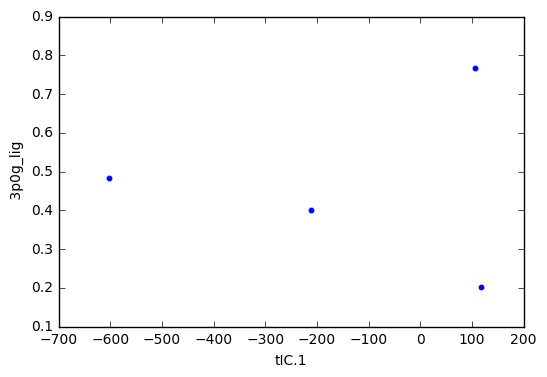

In [749]:
deltas_tica.loc[agonist_states.index].plot(x="tIC.1",y=" 3p0g_lig", kind='scatter')

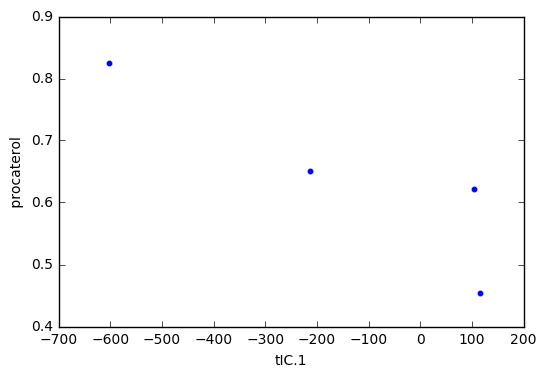

In [750]:
deltas_tica.loc[agonist_states.index].plot(x="tIC.1",y=procaterol, kind='scatter')

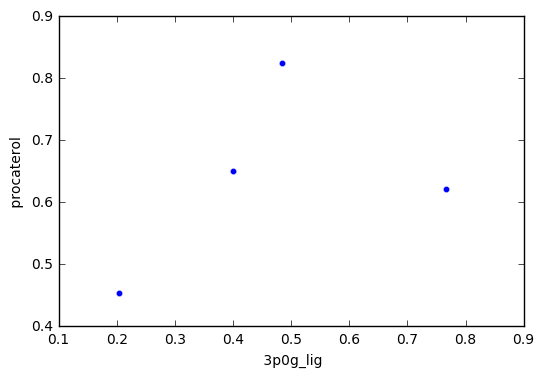

In [751]:
deltas_tica.loc[agonist_states.index].plot(x=" 3p0g_lig",y=procaterol, kind='scatter')

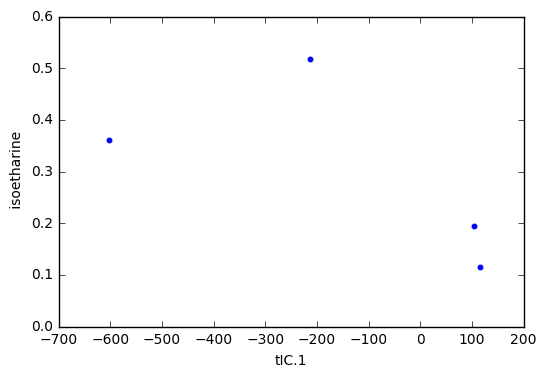

In [752]:
deltas_tica.loc[agonist_states.index].plot(x="tIC.1",y=" isoetharine", kind='scatter')

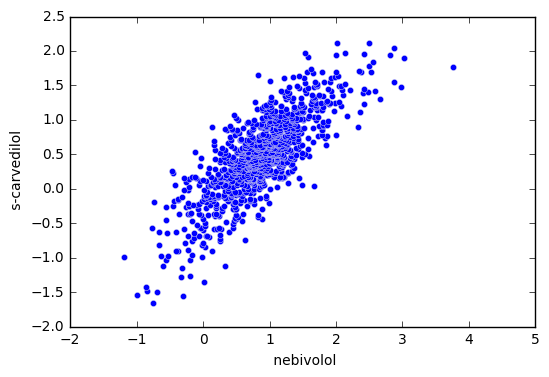

In [215]:
deltas_tica.plot(x=" nebivolol",y=" s-carvedilol", kind='scatter')

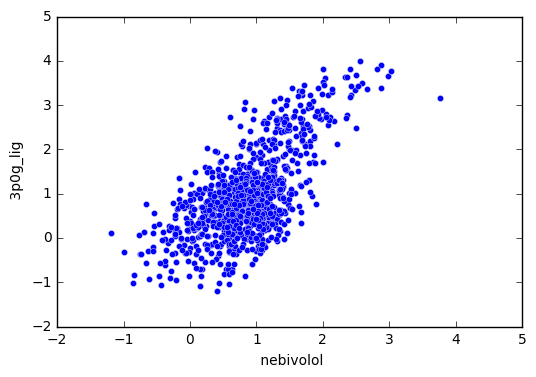

In [217]:
deltas_tica.plot(x=" nebivolol",y=" 3p0g_lig", kind='scatter')

In [755]:
import scipy.stats as stats
print(stats.pearsonr(deltas_tica[" s-carazolol"].values, deltas_tica["tIC.1"].values))
print(stats.pearsonr(deltas_tica[" s-carvedilol"].values, deltas_tica["tIC.1"].values))
print(stats.pearsonr(deltas_tica[" nebivolol"].values, deltas_tica["tIC.1"].values))
print(stats.pearsonr(deltas_tica[" xamoterol"].values, deltas_tica["tIC.1"].values))
print(stats.pearsonr(deltas_tica[" Compound_A"].values, deltas_tica["tIC.1"].values))
print(stats.pearsonr(deltas_tica[" Compound_B"].values, deltas_tica["tIC.1"].values))
print(stats.pearsonr(deltas_tica[" Compound_C"].values, deltas_tica["tIC.1"].values))
print(stats.pearsonr(deltas_tica[" Compound_D"].values, deltas_tica["tIC.1"].values))
print(stats.pearsonr(deltas_tica[" Compound_E"].values, deltas_tica["tIC.1"].values))
print(stats.pearsonr(deltas_tica[" Compound_F"].values, deltas_tica["tIC.1"].values))
print(stats.pearsonr(deltas_tica[" Compound_G"].values, deltas_tica["tIC.1"].values))
print(stats.pearsonr(deltas_tica[" Compound_H"].values, deltas_tica["tIC.1"].values))
print(stats.pearsonr(deltas_tica[" Compound_I"].values, deltas_tica["tIC.1"].values))
print(stats.pearsonr(deltas_tica[" Compound_J"].values, deltas_tica["tIC.1"].values))

(0.24977327796208917, 0.01220407459154862)
(0.29461389556573003, 0.0029257354969715135)
(0.5538268115105518, 2.2746685194515482e-09)
(0.26266959779138405, 0.008285626497865968)
(0.35354530401227519, 0.0003082497117652757)
(0.3004964054347421, 0.0023837711580481399)
(0.29492214846469067, 0.0028947966604223854)
(0.36764093822732125, 0.00016798282153076587)
(0.35017300316309091, 0.00035496818374967199)
(0.31368015812790578, 0.0014830666248246485)
(0.32956512702854057, 0.00081316705675007616)
(0.36307862274930214, 0.0002050831980623532)
(0.28709793649687398, 0.0037781312192433501)
(0.29660239816764827, 0.0027312642749606634)


In [120]:
import scipy.stats as stats
t = "tIC.5"
deltas_inactive = deltas_tica.loc[(deltas_tica["tm6_tm3_dist"] < 16.)]# & (deltas_tica["tIC.1"] > 0.)]

print(stats.pearsonr(deltas_inactive[" s-carazolol"].values, deltas_inactive[t].values))
print(stats.pearsonr(deltas_inactive[" s-carvedilol"].values, deltas_inactive[t].values))
print(stats.pearsonr(deltas_inactive[" nebivolol"].values, deltas_inactive[t].values))
print(stats.pearsonr(deltas_inactive[" xamoterol"].values, deltas_inactive[t].values))
print(stats.pearsonr(deltas_inactive[" 3p0g_lig"].values, deltas_inactive[t].values))
print(stats.pearsonr(deltas_inactive[" isoetharine"].values, deltas_inactive[t].values))
print(stats.pearsonr(deltas_inactive[" r_isopreterenol"].values, deltas_inactive[t].values))
print(stats.pearsonr(deltas_inactive[procaterol].values, deltas_inactive[t].values))
#print(stats.pearsonr(deltas_inactive[" Compound_D"].values, deltas_inactive[t].values))
#print(stats.pearsonr(deltas_tica[" Compound_E"].values, deltas_tica[t].values))
#print(stats.pearsonr(deltas_tica[" Compound_F"].values, deltas_tica[t].values))
#print(stats.pearsonr(deltas_tica[" Compound_G"].values, deltas_tica[t].values))
#print(stats.pearsonr(deltas_tica[" Compound_H"].values, deltas_tica[t].values))
#print(stats.pearsonr(deltas_tica[" Compound_I"].values, deltas_tica[t].values))
#print(stats.pearsonr(deltas_tica[" Compound_J"].values, deltas_tica[t].values))

(0.21796251707672126, 0.029369905905074989)
(0.20196167208063878, 0.043900443365920847)
(0.27981657764808504, 0.0048092485340481741)
(0.40048620792695894, 3.6482496430973166e-05)
(0.31103802841277284, 0.0016338707279867305)
(0.21512616382188229, 0.031598814199455282)
(0.2186947111544188, 0.028816644118427225)
(0.18697853459303571, 0.06249867487793178)


In [756]:
deltas_tica.loc[biased_antagonist_states.index][[" 3p0g_lig", " nebivolol", " s-carvedilol", " s-carazolol", "tIC.1", "tIC.4", "tm6_tm3_dist", "tIC.3"]]

,3p0g_lig,nebivolol,s-carvedilol,s-carazolol,tIC.1,tIC.4,tm6_tm3_dist,tIC.3
cluster43,0.342258,0.585829,0.649763,0.223604,343.215932,-200.972444,15.096400,427.928737
cluster80,0.201858,0.823429,0.704563,0.279204,847.962433,-197.654840,8.162954,12.544195
cluster26,0.697458,0.752629,0.369763,-0.156396,793.797922,66.929054,8.271168,391.098460
cluster69,0.058192,0.284929,0.491880,-0.184580,575.414087,-205.222601,13.172779,398.287635
cluster38,0.119058,0.378629,0.539363,0.149604,768.927627,-224.604542,7.860789,-9.916779


In [757]:
deltas_tica.loc[agonist_states.index][[" 3p0g_lig", " nebivolol", " s-carvedilol", " s-carazolol", "tIC.1", "tIC.4", "tm6_tm3_dist", "rmsd_npxxy_active", "tIC.3"]]

,3p0g_lig,nebivolol,s-carvedilol,s-carazolol,tIC.1,tIC.4,tm6_tm3_dist,rmsd_npxxy_active,tIC.3
cluster60,0.203058,-0.510571,-0.929837,-0.775596,116.271286,92.133989,8.716472,0.872951,-111.712249
cluster36,0.766658,0.009429,-0.639837,-0.331996,104.811022,51.074030,13.875161,0.749558,-148.971088
cluster62,0.400692,-0.376738,-0.528953,-0.359580,-212.660540,68.406126,14.459442,0.356988,-167.491005
cluster21,0.484442,-0.637154,-0.316870,-0.132080,-601.813690,123.397937,12.426038,0.798438,-168.735170


(array([80, 89, 94]),)


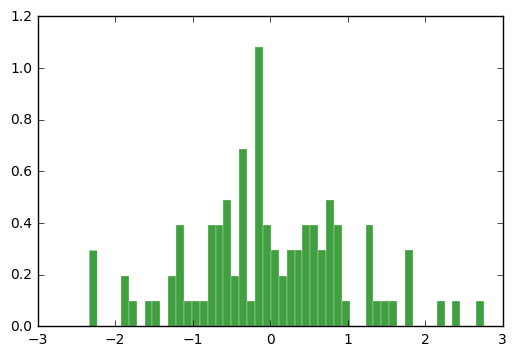

,s-carazolol,nebivolol,s-carvedilol,3p0g_lig,tIC.1,tIC.2,tIC.3,tIC.4
cluster13,-0.374163,-0.341738,0.222713,-0.672642,218.602344,767.688438,687.996319,194.026631
cluster26,-0.156396,0.752629,0.369763,0.697458,793.797922,-137.092495,391.098460,66.929054
cluster69,-0.184580,0.284929,0.491880,0.058192,575.414087,532.524626,398.287635,-205.222601


In [758]:
x = deltas_tica[" s-carvedilol"].values - deltas_tica[" s-carazolol"].values
x = (x - np.mean(x))/np.std(x)
print(np.where(x > 2.))
n, bins, patches = plt.hist(x, 50, normed=1, facecolor='green', alpha=0.75)

#l = plt.plot(bins, y, 'r--', linewidth=1)
plt.show()
deltas_tica.iloc[np.where(x>2.)][[" s-carazolol", " nebivolol", " s-carvedilol", " 3p0g_lig", "tIC.1", "tIC.2", "tIC.3", "tIC.4"]]



(array([ 9, 44, 47]),)


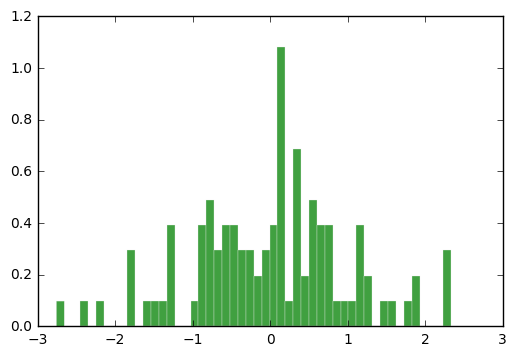

,s-carazolol,nebivolol,s-carvedilol,3p0g_lig,tIC.1,tIC.2,tIC.3,tIC.4
cluster40,-0.285830,-0.500488,-0.845203,-0.234725,387.046698,31.435175,-169.900419,316.307936
cluster49,0.336004,0.242229,-0.247437,0.376258,714.294737,-27.212609,-98.696675,100.758226
cluster0,0.356670,0.294929,-0.224787,-0.076392,674.128220,-28.152244,-22.450247,120.769651


In [759]:
x = deltas_tica[" s-carazolol"].values - deltas_tica[" s-carvedilol"].values
x = (x - np.mean(x))/np.std(x)
print(np.where(x > 2.))
n, bins, patches = plt.hist(x, 50, normed=1, facecolor='green', alpha=0.75)

#l = plt.plot(bins, y, 'r--', linewidth=1)
plt.show()
deltas_tica.iloc[np.where(x>2.)][[" s-carazolol", " nebivolol", " s-carvedilol", " 3p0g_lig", "tIC.1", "tIC.2", "tIC.3", "tIC.4"]]




In [760]:
deltas_tica.loc[agonist_states.index]

,salmeterol,Compound_D,isoetharine,Compound_C,Compound_I,Compound_G,r_isopreterenol,3p0g_lig,Compound_J,r_epinephrine,nebivolol,Compound_H,Compound_B,Compound_E,s-carvedilol,s-carazolol,Carvedilol,Compound_A,Compound_F,xamoterol,procaterol,tIC.1,tIC.2,tIC.3,tIC.4,tIC.5,tIC.6,tIC.7,tIC.8,tIC.9,tIC.10,tIC.11,tIC.12,tIC.13,tIC.14,tIC.15,tIC.16,tIC.17,tIC.18,tIC.19,tIC.20,tIC.21,tIC.22,tIC.23,tIC.24,tIC.25,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active
cluster60,-0.653774,-0.367133,0.115624,-0.357262,-0.364525,-0.143755,0.221198,0.203058,-0.383138,0.265889,-0.510571,-0.035664,-0.220203,-0.273559,-0.929837,-0.775596,-0.798943,-0.212586,-0.353769,-0.314254,0.453772,116.271286,23.097325,-111.712249,92.133989,-155.131202,97.799857,62.635455,-1.846927,-10.302984,-19.132170,-67.487759,10.428907,-7.578974,0.590597,-12.670010,-28.407755,-1.844477,-14.351784,7.118589,-9.314433,-21.403590,4.484128,-6.015383,8.325767,-2.726150,8.716472,0.551858,0.872951,0.693254,1.479639
cluster36,0.153826,0.133667,0.193624,0.156338,0.163475,0.235845,0.271598,0.766658,-0.057938,0.295089,0.009429,0.072336,0.112597,0.227241,-0.639837,-0.331996,-0.041743,-0.009386,0.308631,0.121346,0.621372,104.811022,637.698272,-148.971088,51.074030,-71.913907,-155.951952,21.540322,-16.547689,-28.454239,62.752321,-38.068170,-26.915706,7.977575,13.035008,-16.735585,-19.012349,18.770410,-3.242310,45.848313,-0.489772,1.769976,19.979377,-6.811692,14.115359,-3.312668,13.875161,0.789207,0.749558,1.002400,1.127812
cluster62,0.029793,0.045684,0.517974,-0.177229,-0.043692,0.226228,0.523282,0.400692,-0.117922,0.419273,-0.376738,0.196420,0.087764,-0.147376,-0.528953,-0.359580,-0.016843,-0.014536,-0.049636,0.045196,0.650255,-212.660540,659.895230,-167.491005,68.406126,-144.626812,-162.411094,74.779939,-23.573043,-28.177069,33.376631,-169.097776,-106.303825,18.643704,92.292715,1.378127,-13.113557,10.556360,-24.407954,16.047796,-30.057131,8.693294,-1.958029,15.578143,-10.742449,4.546637,14.459442,1.056752,0.356988,1.563351,0.725105
cluster21,-0.336040,-0.350983,0.360474,-0.136812,0.200475,-0.000022,0.361615,0.484442,-0.202505,0.235939,-0.637154,-0.082747,-0.206403,0.080124,-0.316870,-0.132080,-0.409760,-0.286619,-0.045469,0.033529,0.824422,-601.813690,333.272348,-168.735170,123.397937,29.877755,106.712964,53.299140,21.549073,5.540675,-113.894351,35.521070,-16.905466,-21.740475,0.548570,-3.604823,-11.375415,-8.065468,81.560658,11.665270,-17.034599,-0.565871,8.440069,30.865839,-2.145801,-2.225441,12.426038,0.532306,0.798438,0.557545,1.466520


In [223]:
agonist_population = new_populations.loc[agonist_states.index].sum(axis=0)
agonist_ori = msm_cluster_eq_pops_df.loc[agonist_states.index].sum().values[0]
agonist_change = agonist_population.divide(agonist_ori)


biased_population = new_populations.loc[biased_antagonist_states.index].sum(axis=0)
biased_antagonist_ori = msm_cluster_eq_pops_df.loc[biased_antagonist_states.index].sum().values[0]
biased_antagonist_change = biased_population.divide(biased_antagonist_ori)



gprot_population = new_populations.loc[gprot_agonist_states.index].sum(axis=0)
gprot_ori = msm_cluster_eq_pops_df.loc[gprot_agonist_states.index].sum().values[0]
gprot_change = gprot_population.divide(gprot_ori)



arrestin_agonist_population = new_populations.loc[arrestin_agonist_states.index].sum(axis=0)
arrestin_agonist_ori = msm_cluster_eq_pops_df.loc[arrestin_agonist_states.index].sum().values[0]
arrestin_agonist_change = arrestin_agonist_population.divide(arrestin_agonist_ori)

biased_vs_agonist_state_change = biased_antagonist_change.divide(agonist_change)
biased_vs_agonist_state_change /= biased_vs_agonist_state_change[" r_isopreterenol"]

biased_antagonist_vs_gprot_agonist_state_change = biased_antagonist_change.divide(gprot_change)
biased_antagonist_vs_gprot_agonist_state_change /= biased_antagonist_vs_gprot_agonist_state_change[" r_isopreterenol"]




In [224]:
print("Agonist state changes:")
print(agonist_change)
print("Arrestin antagonist state  changes:")
print(biased_antagonist_change)
print("Gprot agonist state changes:")
print(gprot_change)
print("Arrestin agonist state changes:")
print(arrestin_agonist_change)
print("Biased antagonist state change vs. Agonist state change")
print(biased_vs_agonist_state_change)
print("Biased antagonist vs Gprot agonist state change")
print(biased_antagonist_vs_gprot_agonist_state_change)

Agonist state changes:
 nebivolol         NaN
 3p0g_lig          NaN
 s-carazolol       NaN
 xamoterol         NaN
 s-carvedilol      NaN
 isoetharine       NaN
 r_isopreterenol   NaN
 r_epinephrine     NaN
 procaterol        NaN
 s-atenolol        NaN
dtype: float64
Arrestin antagonist state  changes:
 nebivolol          1.203519
 3p0g_lig           0.809543
 s-carazolol        0.682841
 xamoterol          1.021686
 s-carvedilol       0.692220
 isoetharine        0.932178
 r_isopreterenol    0.988428
 r_epinephrine      1.035788
 procaterol         0.723312
 s-atenolol         1.395555
dtype: float64
Gprot agonist state changes:
 nebivolol         NaN
 3p0g_lig          NaN
 s-carazolol       NaN
 xamoterol         NaN
 s-carvedilol      NaN
 isoetharine       NaN
 r_isopreterenol   NaN
 r_epinephrine     NaN
 procaterol        NaN
 s-atenolol        NaN
dtype: float64
Arrestin agonist state changes:
 nebivolol          0.296676
 3p0g_lig           1.185777
 s-carazolol        0.83879

In [175]:
gprot_ligands = [lig for lig in population_deltas.columns.values if "procaterol" in lig or "r_isopreterenol" in lig]
non_gprot_ligands = [lig for lig in population_deltas.columns.values if lig not in gprot_ligands]
gprot_states = deltas_tica.loc[(deltas_tica[gprot_ligands].min(axis=1) > deltas_tica[non_gprot_ligands].max(axis=1)) & (deltas_tica[gprot_ligands].min(axis=1) > 1.0) & (deltas_tica["tm6_tm3_dist"] > 12.)]
gprot_states.sort(" r_isopreterenol", ascending=False)

,salmeterol,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol,tIC.1,tIC.2,tIC.3,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active
cluster62,1.042750,2.350123,2.369872,1.923532,1.996948,0.528025,0.410230,1.068112,2.922105,-212.660540,659.895230,-167.491005,14.459442,1.056752,0.356988,1.563351,0.725105
cluster5,1.036029,1.602577,2.062114,1.644930,1.607593,0.808610,0.602582,1.437492,1.758480,-41.800904,603.737790,-65.628949,13.951230,1.013675,0.431602,1.386692,0.970817
cluster94,1.080634,1.404267,1.873225,1.674876,1.665756,0.705603,1.639604,1.364936,2.080198,-644.570245,455.884642,-175.798493,12.680894,0.445717,0.870569,0.479588,1.444026


In [225]:
#arrestin_agonists = [lig for lig in population_deltas.columns.values if "3p0g" in lig]
#non_arrestin_agonists = [lig for lig in population_deltas.columns.values if lig not in arrestin_agonists]
agonists = [lig for lig in population_deltas.columns.values if lig not in biased_ligands]
bias_3p0g = [" 3p0g_lig"]
non_bias_agonists = [lig for lig in agonists if lig not in [" isoetharine", " 3p0g_lig"]]
arrestin_active_states = deltas_tica.loc[(deltas_tica[bias_3p0g].min(axis=1) > deltas_tica[non_bias_agonists].max(axis=1)) & (deltas_tica[bias_3p0g].min(axis=1) > 1.0) & (deltas_tica["tm6_tm3_dist"] > 11.)]
arrestin_active_states.sort(" 3p0g_lig", ascending=False)


,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol,tIC.1,tIC.2,tIC.3,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active
cluster36,1.370298,1.560615,3.542474,1.625325,1.006640,0.341251,1.215009,2.788561,104.811022,637.698272,-148.971088,13.875161,0.789207,0.749558,1.002400,1.127812
cluster87,1.330347,1.485114,2.102732,1.436371,0.623564,0.472024,1.026851,1.488751,-379.289933,522.431203,-134.208048,13.201396,0.579967,0.788119,0.854676,1.255467
cluster43,0.768050,0.716640,1.726156,0.979656,2.600463,2.893885,1.969585,0.741261,343.215932,489.592359,427.928737,15.096400,0.753423,1.084534,1.843255,1.699191
cluster28,1.051087,1.533443,1.576717,1.366959,0.853801,0.817361,0.930550,1.012399,-154.047140,326.560224,-42.306232,12.598850,0.720824,0.633338,1.089140,1.119844
cluster4,1.418142,0.988796,1.348705,0.801471,0.408582,0.504854,0.833383,1.133350,299.819550,590.250108,-86.715218,13.216602,0.728719,0.877427,0.944649,1.191570
cluster69,0.831374,0.827845,1.071180,0.915231,1.569093,2.216145,0.928819,0.670350,575.414087,532.524626,398.287635,13.172779,0.735695,0.996973,1.648401,1.572560


In [206]:
arrestin_active_states = deltas_tica.loc[(deltas_tica[bias_3p0g].min(axis=1) > deltas_tica[non_bias_agonists].max(axis=1)) & (deltas_tica[bias_3p0g].min(axis=1) > 1.0) & (deltas_tica["tm6_tm3_dist"] > 12.)]
arrestin_active_states.sort(" 3p0g_lig", ascending=False)

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol,tIC.1,tIC.2,tIC.3,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active
cluster36,1.370298,1.560615,3.542474,1.625325,1.006640,0.341251,1.215009,2.788561,104.811022,637.698272,-148.971088,13.875161,0.789207,0.749558,1.002400,1.127812
cluster87,1.330347,1.485114,2.102732,1.436371,0.623564,0.472024,1.026851,1.488751,-379.289933,522.431203,-134.208048,13.201396,0.579967,0.788119,0.854676,1.255467
cluster43,0.768050,0.716640,1.726156,0.979656,2.600463,2.893885,1.969585,0.741261,343.215932,489.592359,427.928737,15.096400,0.753423,1.084534,1.843255,1.699191
cluster28,1.051087,1.533443,1.576717,1.366959,0.853801,0.817361,0.930550,1.012399,-154.047140,326.560224,-42.306232,12.598850,0.720824,0.633338,1.089140,1.119844
cluster69,0.831374,0.827845,1.071180,0.915231,1.569093,2.216145,0.928819,0.670350,575.414087,532.524626,398.287635,13.172779,0.735695,0.996973,1.648401,1.572560


In [205]:
msm_cluster_eq_pops_df.rank(ascending=False).loc[arrestin_active_states.index]

,0
cluster43,71
cluster69,86
cluster28,74
cluster87,87
cluster36,39


In [172]:
pd.concat([population_deltas.rank(ascending=False), tica_cluster_averages_df, pnas_cluster_averages_df], axis=1).sort(" 3p0g_lig")

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol,tIC.1,tIC.2,tIC.3,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active
cluster36,14,8,1,6,27,88,23,4,104.811022,637.698272,-148.971088,13.875161,0.789207,0.749558,1.002400,1.127812
cluster26,10,40,2,20,2,10,1,66,793.797922,-137.092495,391.098460,8.271168,0.594835,0.908593,0.580696,1.614681
cluster64,30,18,3,42,19,50,51,38,790.489758,8.683685,-101.913731,8.283311,0.553519,0.954337,0.347637,1.520873
cluster78,23,22,4,34,11,20,19,48,714.488006,58.894827,-78.636117,8.220997,0.583852,0.887841,0.376705,1.422045
cluster21,3,5,5,10,89,65,33,1,-601.813690,333.272348,-168.735170,12.426038,0.532306,0.798438,0.557545,1.466520
cluster87,18,12,6,13,47,78,32,15,-379.289933,522.431203,-134.208048,13.201396,0.579967,0.788119,0.854676,1.255467
cluster61,1,3,7,2,24,51,6,3,-529.578172,443.664537,-157.267036,12.545375,0.460297,0.887250,0.523941,1.436082
cluster62,2,1,8,1,58,82,30,2,-212.660540,659.895230,-167.491005,14.459442,1.056752,0.356988,1.563351,0.725105
cluster49,20,7,9,18,13,55,17,37,714.294737,-27.212609,-98.696675,8.136475,0.572205,0.931885,0.353415,1.513465
cluster43,61,65,10,43,3,3,5,53,343.215932,489.592359,427.928737,15.096400,0.753423,1.084534,1.843255,1.699191


In [177]:
deltas_tica.loc[(deltas_tica["tm6_tm3_dist"] > 12.0)].sort(" s-carvedilol", ascending=False)

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol,tIC.1,tIC.2,tIC.3,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active
cluster43,0.768050,0.716640,1.726156,0.979656,2.600463,2.893885,1.969585,0.741261,343.215932,489.592359,427.928737,15.096400,0.753423,1.084534,1.843255,1.699191
cluster69,0.831374,0.827845,1.071180,0.915231,1.569093,2.216145,0.928819,0.670350,575.414087,532.524626,398.287635,13.172779,0.735695,0.996973,1.648401,1.572560
cluster77,1.278656,1.328249,1.698265,1.469844,1.659859,1.963987,1.071293,2.009007,121.923243,723.868901,196.638431,13.736668,0.799407,0.738928,1.817884,1.406989
cluster2,0.852537,1.097659,0.992950,1.128032,1.362586,1.952210,1.112769,1.082882,-573.368234,569.151380,-159.014243,13.952347,0.456261,0.890838,0.754507,1.323048
cluster12,0.518096,0.424734,0.362556,0.787197,1.476071,1.770853,0.551741,0.347772,-176.971711,225.319862,426.898254,12.663861,0.713618,0.670172,2.190558,1.774371
cluster94,1.405731,1.876251,1.675907,1.667353,0.706674,1.640593,1.367450,2.082818,-644.570245,455.884642,-175.798493,12.680894,0.445717,0.870569,0.479588,1.444026
cluster97,1.502912,1.352727,0.900506,1.337431,0.804389,1.507679,1.487546,1.730774,-845.173003,-23.442572,-107.555631,12.221868,0.448232,0.865894,0.512939,1.400361
cluster29,1.413701,1.037073,0.978358,0.921914,1.242097,1.505756,0.885656,1.192522,565.733529,463.517202,-16.628684,12.369645,0.618264,0.884583,0.541440,1.392939
cluster13,0.628477,0.512369,0.311215,0.674318,0.542308,1.389833,0.391004,0.405774,218.602344,767.688438,687.996319,14.429488,0.701767,0.984883,2.405524,1.722553
cluster54,1.012971,0.968852,0.791069,1.152943,0.663009,1.291537,1.075761,1.216793,-930.864745,60.676379,-132.420867,12.537092,0.443572,0.864266,0.459767,1.407731


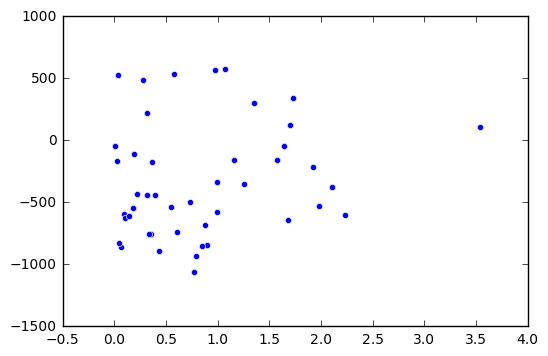

In [179]:
plt.scatter(deltas_tica.loc[(deltas_tica["tm6_tm3_dist"] > 12.0)][" 3p0g_lig"].values, deltas_tica.loc[(deltas_tica["tm6_tm3_dist"] > 12.0)]["tIC.1"].values)

In [ ]:
plt.scatter(df_agg

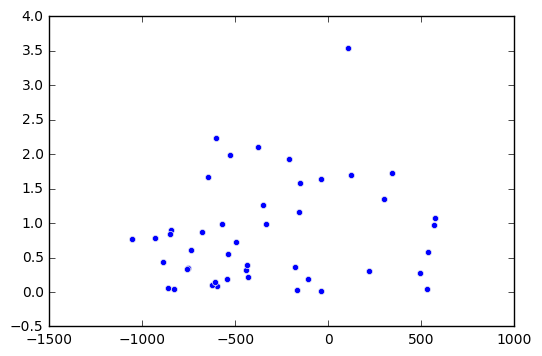

In [190]:
plt.scatter(deltas_tica.loc[(deltas_tica["tm6_tm3_dist"] > 12.0)]["tIC.1"].values, deltas_tica.loc[(deltas_tica["tm6_tm3_dist"] > 12.0)][" 3p0g_lig"].values)

In [285]:
agonist_states = deltas_tica.loc[(deltas_tica[biased_ligands].max(axis=1) < deltas_tica[non_bias_agonists].min(axis=1)) & (deltas_tica[non_biased_ligands].min(axis=1) > 1.0) & (deltas_tica["tm6_tm3_dist"] > 12.)]
agonist_states.sort(" r_epinephrine", ascending=False)

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol,tIC.1,tIC.2,tIC.3,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active
cluster62,2.352573,2.373701,1.924717,1.998863,0.528826,0.410477,1.070080,2.925784,-212.660540,659.895230,-167.491005,14.459442,1.056752,0.356988,1.563351,0.725105
cluster44,1.346407,1.730064,0.731424,1.851729,0.454010,0.349451,0.842959,1.253497,-494.451102,242.476838,-101.512880,13.648558,0.768528,0.592951,1.099214,1.002938
cluster39,1.523470,1.475444,1.258578,1.757012,0.569734,0.386222,0.868410,1.715558,-348.639104,337.188926,-107.947132,12.538080,0.586352,0.752953,0.848097,1.262639
cluster83,1.362222,1.496560,1.159027,1.519625,0.451449,0.645079,0.784670,1.609003,-159.980646,488.922919,-110.429884,12.718732,0.718892,0.652932,0.935480,1.075192
cluster59,1.060566,1.419611,0.994201,1.454037,0.921532,1.131982,0.993272,1.190149,-332.784644,161.781545,4.512933,13.285576,0.536252,0.805594,0.838691,1.194183


In [286]:
agonist_population = new_populations.loc[agonist_states.index].sum(axis=0)
agonist_ori = msm_cluster_eq_pops_df.loc[agonist_states.index].sum().values[0]
agonist_change = agonist_population.divide(agonist_ori)

#gprot_population = new_populations.loc[agonist_states.index].sum(axis=0)
#gprot_ori = msm_cluster_eq_pops_df.loc[agonist_states.index].sum().values[0]
#gprot_change = agonist_population.divide(agonist_ori)

biased_population = new_populations.loc[biased_states.index].sum(axis=0)
biased_ori = msm_cluster_eq_pops_df.loc[biased_states.index].sum().values[0]
biased_change = biased_population.divide(biased_ori)

biased_vs_agonist_state_change = biased_change.divide(agonist_change)

In [287]:
print(agonist_change)
print(biased_change) 
print(biased_vs_agonist_state_change)

 isoetharine        1.540001
 r_isopreterenol    1.731408
 3p0g_lig           1.210394
 r_epinephrine      1.730469
 nebivolol          0.599888
 s-carvedilol       0.595221
 xamoterol          0.926634
 procaterol         1.744847
dtype: float64
 isoetharine        1.216268
 r_isopreterenol    1.020577
 3p0g_lig           2.165464
 r_epinephrine      1.065143
 nebivolol          2.690099
 s-carvedilol       2.168303
 xamoterol          2.165515
 procaterol         0.748639
dtype: float64
 isoetharine        0.789783
 r_isopreterenol    0.589449
 3p0g_lig           1.789057
 r_epinephrine      0.615523
 nebivolol          4.484337
 s-carvedilol       3.642854
 xamoterol          2.336968
 procaterol         0.429057
dtype: float64


In [135]:
agonist_ligands

['3p0g_lig', 'procaterol', 'r_epinephrine', 'r_isopreterenol']

In [128]:
non_biased_ligands

[' isoetharine',
 ' r_isopreterenol',
 ' 3p0g_lig',
 ' r_epinephrine',
 ' procaterol ',
 'tIC.1',
 'tIC.2',
 'tIC.3',
 'tm6_tm3_dist',
 'rmsd_npxxy_inactive',
 'rmsd_npxxy_active',
 'rmsd_connector_inactive',
 'rmsd_connector_active']

In [121]:
print(biased_ligands)
print(non_biased_ligands)

[' nebivolol', ' s-carvedilol', ' xamoterol']
[' isoetharine', ' r_isopreterenol', ' 3p0g_lig', ' r_epinephrine', ' procaterol ', 'tIC.1', 'tIC.2', 'tIC.3', 'tm6_tm3_dist', 'rmsd_npxxy_inactive', 'rmsd_npxxy_active', 'rmsd_connector_inactive', 'rmsd_connector_active']


In [39]:
docking_tica_msm_ranked = pd.concat([aggregate_docking_msm.rank(axis=0, ascending=False), tica_cluster_averages_df, pnas_cluster_averages_df], axis=1).sort(" s-carvedilol", ascending=False)
docking_tica_msm_ranked.sort(" s-carvedilol", ascending=True).iloc[0:15]


,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol,tIC.1,tIC.2,tIC.3,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active
cluster16,20,20,17,19.0,4,1,3,21,298.327555,-155.705678,-41.344052,8.098881,0.504904,0.989428,0.403042,1.487263
cluster80,21,54,19,77.0,1,2,2,50,847.962433,-84.929557,12.544195,8.162954,0.538104,0.956173,0.360018,1.498056
cluster43,60,64,10,42.0,3,3,5,53,343.215932,489.592359,427.928737,15.096400,0.753423,1.084534,1.843255,1.699191
cluster99,38,37,55,47.0,7,4,20,64,528.839801,-143.907087,36.367880,8.145755,0.580873,0.934381,0.452970,1.466344
cluster38,19,31,23,27.0,6,5,11,46,768.927627,-142.754306,-9.916779,7.860789,0.543306,0.942253,0.337654,1.478456
cluster69,53,51,27,48.0,12,6,37,57,575.414087,532.524626,398.287635,13.172779,0.735695,0.996973,1.648401,1.572560
cluster77,18,17,11,10.0,8,7,25,7,121.923243,723.868901,196.638431,13.736668,0.799407,0.738928,1.817884,1.406989
cluster2,51,32,29,28.0,18,8,24,36,-573.368234,569.151380,-159.014243,13.952347,0.456261,0.890838,0.754507,1.323048
cluster68,58,43,52,38.0,44,9,12,58,-585.807198,-608.999177,-65.263290,7.106790,0.446257,0.890274,0.392662,1.386929
cluster26,12,40,2,21.0,2,10,1,67,793.797922,-137.092495,391.098460,8.271168,0.594835,0.908593,0.580696,1.614681


In [95]:
r1 = docking_tica_msm_ranked.loc[(docking_tica_msm_ranked["tIC.1"] < 100) & (docking_tica_msm_ranked["tIC.2"] < -50.)].index
r2 = docking_tica_msm_ranked.loc[(docking_tica_msm_ranked["tIC.1"] > 100) & (docking_tica_msm_ranked["tIC.2"] < -50.)].index
r3 = docking_tica_msm_ranked.loc[(docking_tica_msm_ranked["tIC.1"] < 100) & (docking_tica_msm_ranked["tIC.2"] > -50.)].index
r4 = docking_tica_msm_ranked.loc[(docking_tica_msm_ranked["tIC.1"] > 100) & (docking_tica_msm_ranked["tIC.2"] > -50.)].index
r3_r4 = docking_tica_msm_ranked.loc[(docking_tica_msm_ranked["tIC.2"] > -50.)].index

In [107]:
docking_tica_msm_ranked.sort(" r_isopreterenol")
s3 = ["cluster62", "cluster61", "cluster36"]
s2 = ["cluster16", "cluster80", "cluster43", "cluster26"]
not_s2 = [cluster for cluster in msm_cluster_names if cluster not in s2]
tm6_out = docking_tica_msm.loc[(docking_tica_msm["tm6_tm3_dist"] > 12.)].index

In [108]:
s3 = 

SyntaxError: invalid syntax (<ipython-input-108-bf34425e99f9>, line 1)

In [109]:
r1_population = new_populations.loc[r1].sum(axis=0)
s2_population = new_populations.loc[s2].sum(axis=0)
not_s2_population = new_populations.loc[not_s2].sum(axis=0)
tm6_out_population = new_populations.loc[tm6_out].sum(axis=0)
s3_population = new_populations.loc[s3].sum(axis=0)
r2_population = new_populations.loc[r2].sum(axis=0)
r3_population = new_populations.loc[r3].sum(axis=0)
r3_r4_population = new_populations.loc[r3_r4].sum(axis=0)
r4_population = new_populations.loc[r4].sum(axis=0)

In [110]:
r1_ori = msm_cluster_eq_pops_df.loc[r1].sum().values[0]
r2_ori = msm_cluster_eq_pops_df.loc[r2].sum().values[0]
s2_ori = msm_cluster_eq_pops_df.loc[s2].sum().values[0]
not_s2_ori = msm_cluster_eq_pops_df.loc[not_s2].sum().values[0]
tm6_out_ori = msm_cluster_eq_pops_df.loc[tm6_out].sum().values[0]
s3_ori = msm_cluster_eq_pops_df.loc[s3].sum().values[0]
r3_ori = msm_cluster_eq_pops_df.loc[r3].sum().values[0]
r4_ori = msm_cluster_eq_pops_df.loc[r4].sum().values[0]
r3_r4_ori = msm_cluster_eq_pops_df.loc[r3_r4].sum().values[0]

In [111]:
r1_change = r1_population.divide(r1_ori)
r2_change = r2_population.divide(r2_ori)
s2_change = s2_population.divide(s2_ori)
not_s2_change = not_s2_population.divide(not_s2_ori)
tm6_out_change = tm6_out_population.divide(tm6_out_ori)
s3_change = s3_population.divide(s3_ori)
r3_change = r3_population.divide(r3_ori)
r4_change = r4_population.divide(r4_ori)
r3_r4_change = r3_r4_population.divide(r3_r4_ori)

print("r1")
print(r1_change)
print("r2")
print(r2_change)
print("r3")
print(r3_change)
print("r4")
print(r4_change)
print("r3_r4")
print(r3_r4_change)
print("r2/r3")
print(r2_change.divide(r3_change))
print("r2/r3_r4")
print(r2_change.divide(r3_r4_change))
print("s2")
print(s2_change)
print("not_s2")
print(not_s2_change)
print("s3")
print(s3_change)
print("s2/s3")
print(s2_change.divide(s3_change))
print("s2_change  / (not_s2_change)")
print(s2_change.divide(not_s2_change))

r1
 isoetharine        0.783033
 r_isopreterenol    0.875911
 3p0g_lig           0.595493
 r_epinephrine      0.931102
 nebivolol          0.510037
 s-carvedilol       0.743357
 xamoterol          0.807095
 procaterol         0.905499
dtype: float64
r2
 isoetharine        1.193953
 r_isopreterenol    0.984929
 3p0g_lig           1.064059
 r_epinephrine      1.025899
 nebivolol          1.809364
 s-carvedilol       1.682270
 xamoterol          1.305664
 procaterol         0.891090
dtype: float64
r3
 isoetharine        1.047316
 r_isopreterenol    1.073517
 3p0g_lig           0.856995
 r_epinephrine      1.104010
 nebivolol          0.600148
 s-carvedilol       0.805911
 xamoterol          0.887365
 procaterol         1.228035
dtype: float64
r4
 isoetharine        1.004016
 r_isopreterenol    1.057596
 3p0g_lig           1.433259
 r_epinephrine      0.951287
 nebivolol          1.166244
 s-carvedilol       0.877943
 xamoterol          1.036521
 procaterol         0.968765
dtype: float64


In [260]:
df = docking_tica_msm.loc[(docking_tica_msm["tIC.1"] < 0.) & (docking_tica_msm["tIC.3"] < 0.)]

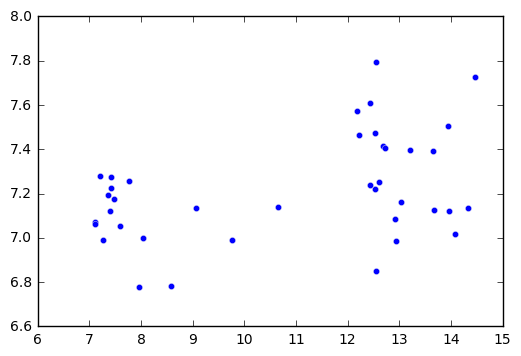

In [267]:
plt.scatter(df["tm6_tm3_dist"].values, df[" isoetharine"].values)

In [258]:
from scipy.stats import pearsonr
print(pearsonr(docking_tica_msm["tm6_tm3_dist"].values, docking_tica_msm[" r_epinephrine"].values))

(0.11246745757125538, 0.26524764370864734)


In [182]:
docking_tica_msm.rank(axis=0,method="min", ascending=False).sort(" s-carvedilol")

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol,tIC.1,tIC.2,tIC.3
cluster16,20,20,17,19,4,1,3,21,29,74,48
cluster80,21,54,19,77,1,2,2,50,1,64,37
cluster43,60,64,10,42,3,3,5,53,27,15,20
cluster99,38,37,55,47,7,4,20,64,22,73,35
cluster38,19,31,23,27,6,5,11,46,7,71,41
cluster69,53,51,27,48,12,6,37,57,18,13,23
cluster77,18,17,11,10,8,7,25,7,35,4,31
cluster2,51,32,29,28,18,8,24,36,74,11,91
cluster68,58,43,52,38,44,9,12,58,76,96,57
cluster26,12,40,2,21,2,10,1,67,4,69,24


In [308]:
population_deltas_tica_pnas = pd.concat([population_deltas, tica_cluster_averages_df, pnas_cluster_averages_df], axis=1)
population_deltas_tica_pnas.sort(" s-carvedilol", ascending=False)

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol,tIC.1,tIC.2,tIC.3,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active
cluster16,1.232318,1.252259,1.522004,1.245550,2.535744,3.428299,2.353619,1.299606,298.327555,-155.705678,-41.344052,8.098881,0.504904,0.989428,0.403042,1.487263
cluster80,1.232772,0.826946,1.391520,0.624552,3.936094,3.229841,2.406859,0.773959,847.962433,-84.929557,12.544195,8.162954,0.538104,0.956173,0.360018,1.498056
cluster43,0.768050,0.716640,1.726156,0.979656,2.600463,2.893885,1.969585,0.741261,343.215932,489.592359,427.928737,15.096400,0.753423,1.084534,1.843255,1.699191
cluster99,1.021306,0.984587,0.591878,0.922281,1.700074,2.790579,1.242931,0.613186,528.839801,-143.907087,36.367880,8.145755,0.580873,0.934381,0.452970,1.466344
cluster38,1.330607,1.152985,1.226420,1.162976,1.897541,2.481350,1.519973,0.843777,768.927627,-142.754306,-9.916779,7.860789,0.543306,0.942253,0.337654,1.478456
cluster69,0.831374,0.827845,1.071180,0.915231,1.569093,2.216145,0.928819,0.670350,575.414087,532.524626,398.287635,13.172779,0.735695,0.996973,1.648401,1.572560
cluster77,1.278656,1.328249,1.698265,1.469844,1.659859,1.963987,1.071293,2.009007,121.923243,723.868901,196.638431,13.736668,0.799407,0.738928,1.817884,1.406989
cluster2,0.852537,1.097659,0.992950,1.128032,1.362586,1.952210,1.112769,1.082882,-573.368234,569.151380,-159.014243,13.952347,0.456261,0.890838,0.754507,1.323048
cluster68,0.794539,0.961821,0.643108,1.053061,0.669118,1.901077,1.495319,0.673659,-585.807198,-608.999177,-65.263290,7.106790,0.446257,0.890274,0.392662,1.386929
cluster26,1.420511,0.982556,3.205327,1.244869,3.527561,1.864235,2.935097,0.598606,793.797922,-137.092495,391.098460,8.271168,0.594835,0.908593,0.580696,1.614681


In [307]:
population_deltas_tica_pnas["rmsd_npxxy_active"].values

array([ 0.35698783,  0.43160227,  0.59295088,  0.63030362,  0.63333797,
        0.65293187,  0.66224384,  0.67017162,  0.73826343,  0.73892808,
        0.74955833,  0.75290483,  0.75295299,  0.78759044,  0.78811908,
        0.79329103,  0.79843843,  0.80559367,  0.81084239,  0.82637632,
        0.82656091,  0.8328324 ,  0.84843314,  0.85063511,  0.85495132,
        0.85540825,  0.85763031,  0.85766172,  0.85895813,  0.86232501,
        0.86251152,  0.86426586,  0.86467093,  0.86565667,  0.86577374,
        0.86589438,  0.86691469,  0.86835039,  0.87056911,  0.87141472,
        0.87295121,  0.87480605,  0.87488991,  0.87489223,  0.87699902,
        0.87742651,  0.87914783,  0.88002205,  0.881428  ,  0.88458323,
        0.88725036,  0.88784051,  0.88837487,  0.88894027,  0.88918275,
        0.8896637 ,  0.89027405,  0.89083838,  0.89165175,  0.89276659,
        0.89389592,  0.89622891,  0.90318012,  0.90502119,  0.90627015,
        0.90643591,  0.90697461,  0.9076165 ,  0.90807325,  0.90

In [301]:
high_tIC2_low_tIC1 = population_deltas_tica_pnas.loc[(population_deltas_tica_pnas["tIC.1"] < 0.) & (population_deltas_tica_pnas["tIC.2"] > 0.)]
high_tIC2_low_tIC1.sort(" s-carvedilol", ascending=False).iloc[0:10]

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol,tIC.1,tIC.2,tIC.3,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active
cluster2,0.852537,1.097659,0.992950,1.128032,1.362586,1.952210,1.112769,1.082882,-573.368234,569.151380,-159.014243,13.952347,0.456261,0.890838,0.754507,1.323048
cluster12,0.518096,0.424734,0.362556,0.787197,1.476071,1.770853,0.551741,0.347772,-176.971711,225.319862,426.898254,12.663861,0.713618,0.670172,2.190558,1.774371
cluster94,1.405731,1.876251,1.675907,1.667353,0.706674,1.640593,1.367450,2.082818,-644.570245,455.884642,-175.798493,12.680894,0.445717,0.870569,0.479588,1.444026
cluster54,1.012971,0.968852,0.791069,1.152943,0.663009,1.291537,1.075761,1.216793,-930.864745,60.676379,-132.420867,12.537092,0.443572,0.864266,0.459767,1.407731
cluster24,0.332867,0.360850,0.189845,0.644038,0.535571,1.254189,0.463497,0.339082,-106.738522,761.986728,513.575626,13.283482,0.856763,0.630304,2.346961,1.548581
cluster59,1.060566,1.419611,0.994201,1.454037,0.921532,1.131982,0.993272,1.190149,-332.784644,161.781545,4.512933,13.285576,0.536252,0.805594,0.838691,1.194183
cluster98,0.854195,1.129516,0.873018,1.202517,0.491969,1.084267,1.041638,1.133037,-680.230596,186.368052,-106.423276,13.670673,0.578283,0.793291,0.762615,1.273547
cluster27,0.542712,0.640192,0.352830,0.829192,0.427876,1.038028,0.641852,0.739226,-753.283076,75.462395,-101.061203,12.542440,0.461659,0.889664,0.559422,1.386004
cluster89,0.252019,0.272477,0.182114,0.401892,0.652249,1.017059,0.428330,0.277180,-543.447699,676.215888,471.378630,13.114884,0.446686,0.865657,2.561983,1.789429
cluster8,0.913490,0.955904,0.767447,1.068437,0.381532,0.995362,0.901743,1.273813,-1058.032313,97.524387,-123.383999,13.022407,0.435752,0.850635,0.457036,1.523810


In [311]:
population_deltas_tica_pnas.loc[(population_deltas_tica_pnas["tm6_tm3_dist"] > 12.)].sort(" s-carvedilol", ascending=False)

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol,tIC.1,tIC.2,tIC.3,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active
cluster43,0.768050,0.716640,1.726156,0.979656,2.600463,2.893885,1.969585,0.741261,343.215932,489.592359,427.928737,15.096400,0.753423,1.084534,1.843255,1.699191
cluster69,0.831374,0.827845,1.071180,0.915231,1.569093,2.216145,0.928819,0.670350,575.414087,532.524626,398.287635,13.172779,0.735695,0.996973,1.648401,1.572560
cluster77,1.278656,1.328249,1.698265,1.469844,1.659859,1.963987,1.071293,2.009007,121.923243,723.868901,196.638431,13.736668,0.799407,0.738928,1.817884,1.406989
cluster2,0.852537,1.097659,0.992950,1.128032,1.362586,1.952210,1.112769,1.082882,-573.368234,569.151380,-159.014243,13.952347,0.456261,0.890838,0.754507,1.323048
cluster12,0.518096,0.424734,0.362556,0.787197,1.476071,1.770853,0.551741,0.347772,-176.971711,225.319862,426.898254,12.663861,0.713618,0.670172,2.190558,1.774371
cluster94,1.405731,1.876251,1.675907,1.667353,0.706674,1.640593,1.367450,2.082818,-644.570245,455.884642,-175.798493,12.680894,0.445717,0.870569,0.479588,1.444026
cluster97,1.502912,1.352727,0.900506,1.337431,0.804389,1.507679,1.487546,1.730774,-845.173003,-23.442572,-107.555631,12.221868,0.448232,0.865894,0.512939,1.400361
cluster29,1.413701,1.037073,0.978358,0.921914,1.242097,1.505756,0.885656,1.192522,565.733529,463.517202,-16.628684,12.369645,0.618264,0.884583,0.541440,1.392939
cluster13,0.628477,0.512369,0.311215,0.674318,0.542308,1.389833,0.391004,0.405774,218.602344,767.688438,687.996319,14.429488,0.701767,0.984883,2.405524,1.722553
cluster54,1.012971,0.968852,0.791069,1.152943,0.663009,1.291537,1.075761,1.216793,-930.864745,60.676379,-132.420867,12.537092,0.443572,0.864266,0.459767,1.407731


In [278]:
bias_agonist_averages = pd.concat([population_deltas[[" nebivolol", " s-carvedilol", " xamoterol"]].mean(axis=1), population_deltas[[" r_epinephrine", " r_isopreterenol", " 3p0g_lig"]].mean(axis=1)], axis=1)
bias_agonist_averages.columns = ["biased_ligands", "agonist_ligands"]
bias_agonist_averages.sort("biased_ligands", ascending=False).iloc[0:10]

,biased_ligands,agonist_ligands
cluster80,3.190931,0.947672
cluster26,2.775631,1.810917
cluster16,2.772554,1.339937
cluster43,2.487978,1.140817
cluster38,1.966288,1.180793
cluster99,1.911195,0.832916
cluster74,1.844567,0.738967
cluster9,1.620396,0.978438
cluster50,1.584631,0.753860
cluster69,1.571352,0.938085


In [291]:
import grids
reload(grids)
from grids import *
convert_maegz_files_to_pdb("%s/s-carvedilol" %docking_dir, ".maegz", worker_pool=dview)
convert_maegz_files_to_pdb("%s/xamoterol" %docking_dir, ".maegz", worker_pool=dview)
convert_maegz_files_to_pdb("%s/nebivolol" %docking_dir, ".maegz", worker_pool=dview)
convert_maegz_files_to_pdb("%s/r_epinephrine" %docking_dir, ".maegz", worker_pool=dview)
convert_maegz_files_to_pdb("%s/r_isopreterenol" %docking_dir, ".maegz", worker_pool=dview)
convert_maegz_files_to_pdb("%s/3p0g_lig" %docking_dir, ".maegz", worker_pool=dview)


In [290]:
len(rc.ids)

273

In [211]:
population_deltas.sort(" s-carvedilol", ascending=False).rank(ascending=False).iloc[0:10]

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol
cluster16,22,21,17,19,4,1,3,20
cluster80,21,55,18,75,1,2,2,49
cluster43,61,65,10,43,3,3,5,53
cluster99,39,38,55,48,7,4,21,64
cluster38,17,29,22,26,6,5,10,46
cluster69,54,54,27,51,12,6,39,61
cluster77,19,17,11,11,8,7,29,7
cluster2,52,32,30,28,18,8,24,36
cluster68,58,42,52,38,43,9,11,57
cluster26,10,40,2,20,2,10,1,66


In [190]:
new_populations.iloc[0:10]

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol
cluster0,0.023293,0.022449,0.018241,0.018158,0.034000,0.014304,0.022259,0.015292
cluster1,0.003234,0.004864,0.002282,0.005375,0.004785,0.008104,0.006692,0.004065
cluster2,0.006286,0.008093,0.007321,0.008317,0.010046,0.014393,0.008204,0.007984
cluster3,0.000949,0.000503,0.000091,0.000965,0.000523,0.000976,0.001060,0.000241
cluster4,0.005586,0.003895,0.005313,0.003157,0.001609,0.001989,0.003283,0.004464
cluster5,0.009288,0.011958,0.009529,0.009316,0.004689,0.003491,0.008338,0.010194
cluster6,0.021841,0.018346,0.016023,0.017788,0.013972,0.011609,0.011631,0.019328
cluster7,0.036518,0.049561,0.029203,0.046024,0.017370,0.014776,0.022262,0.042876
cluster8,0.006114,0.006398,0.005137,0.007152,0.002554,0.006662,0.006036,0.008526
cluster9,0.006288,0.005485,0.008629,0.008287,0.010601,0.011311,0.015186,0.002571


In [191]:
new_populations.sum()

 isoetharine        1
 r_isopreterenol    1
 3p0g_lig           1
 r_epinephrine      1
 nebivolol          1
 s-carvedilol       1
 xamoterol          1
 procaterol         1
dtype: float64

In [195]:
population_iso = new_populations.div(new_populations[" r_isopreterenol"], axis='index')
population_iso.sort(" s-carvedilol", axis=0, ascending=False).iloc[0:10]

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol
cluster76,1.170325,1,0.366074,1.436144,3.744188,6.170514,2.595221,0.812569
cluster92,1.342497,1,0.441618,1.937622,2.769298,5.353520,1.954139,0.772403
cluster42,1.325710,1,0.485656,1.569298,1.884266,4.513692,1.947095,1.152322
cluster12,1.219814,1,0.853609,1.853391,3.475287,4.169326,1.299028,0.818800
cluster41,1.218121,1,0.398484,1.774053,3.511677,4.149107,2.851164,0.652918
cluster43,1.071738,1,2.408680,1.367013,3.628689,4.038131,2.748362,1.034356
cluster20,1.389969,1,0.234980,2.153932,4.443926,4.022011,6.701547,0.599963
cluster80,1.490753,1,1.682721,0.755251,4.759796,3.905746,2.910539,0.935924
cluster48,1.649735,1,0.408912,1.469068,3.156735,3.879794,1.785452,0.604782
cluster15,1.222969,1,0.705449,1.969858,1.983517,3.848880,2.503455,0.697057


In [209]:
population_iso.loc[(population_iso[" isoetharine"] < 1.0) & (population_iso[" 3p0g_lig"] < 1.0) & (population_iso[" r_epinephrine"] < 1.0)]

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol
cluster5,0.776708,1,0.796895,0.779074,0.392089,0.291921,0.697254,0.852453
cluster7,0.736840,1,0.589240,0.928636,0.350476,0.298132,0.449182,0.865120
cluster14,0.701332,1,0.700333,0.907672,0.448635,0.609049,0.470967,0.989034
cluster17,0.866998,1,0.247853,0.972999,0.875936,1.028857,0.404814,0.802877
cluster32,0.782948,1,0.903219,0.798844,1.593795,0.620426,1.360609,0.733646
cluster47,0.744223,1,0.524142,0.931493,0.396745,0.600086,0.711331,0.756318
cluster62,0.991099,1,0.810851,0.842087,0.222786,0.172927,0.450806,1.232584
cluster67,0.773586,1,0.673733,0.910855,0.498013,1.282035,0.747520,0.729871
cluster71,0.972014,1,0.464583,0.836259,0.617485,0.890479,0.998423,0.759636
cluster72,0.867986,1,0.578986,0.921006,0.361742,0.249346,0.470640,0.927822


In [196]:
population_iso.sum()

 isoetharine        110.789519
 r_isopreterenol    100.000000
 3p0g_lig            82.292282
 r_epinephrine      120.080654
 nebivolol          130.874248
 s-carvedilol       159.213096
 xamoterol          131.575778
 procaterol          96.123718
dtype: float64

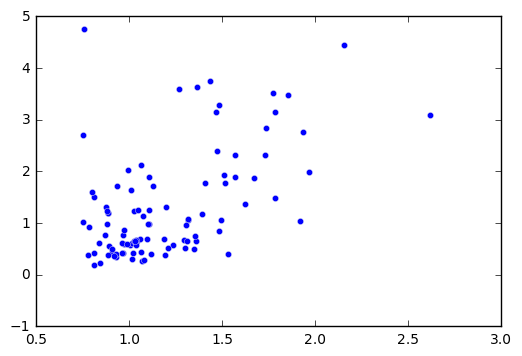

In [202]:
plt.scatter(population_iso[" r_epinephrine"].values, population_iso[" nebivolol"].values)

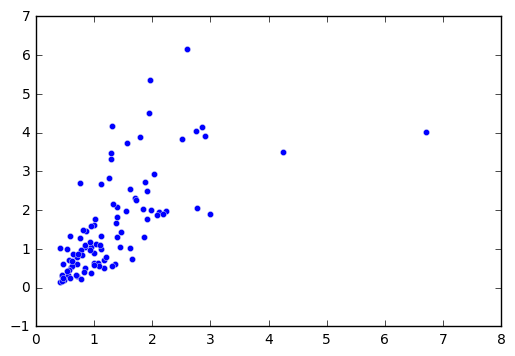

In [233]:
plt.scatter(population_iso[" xamoterol"].values, population_iso[" s-carvedilol"].values)

loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_tICs_1_2_3_100clusters_25samples.h5"...
loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/phi_psi_chi2_allprot_projected.h5"...


,tIC.1,tIC.2,tIC.3
cluster0,674.128220,-28.152244,-22.450247
cluster1,-501.478697,-364.087591,-118.766939
cluster2,-573.368234,569.151380,-159.014243
cluster3,-540.443346,-431.528860,774.028194
cluster4,299.819550,590.250108,-86.715218
cluster5,-41.800904,603.737790,-65.628949
cluster6,140.743640,-219.394936,-76.138061
cluster7,-553.301111,-594.405663,-143.372952
cluster8,-1058.032313,97.524387,-123.383999
cluster9,597.693228,-143.495035,308.665294


In [166]:
population_iso_tica = pd.concat([population_iso, tica_cluster_averages_df], axis=1)
population_iso_tica.iloc[0:10]

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol,tIC.1,tIC.2,tIC.3
cluster0,1.198235,1,0.367556,1.919825,0.890650,2.662384,1.574083,0.991623,674.128220,-28.152244,-22.450247
cluster1,1.869730,1,0.636643,1.405120,1.371328,1.018219,1.134447,0.808317,-501.478697,-364.087591,-118.766939
cluster2,1.600732,1,0.330148,1.511027,1.086665,0.953822,1.539532,0.684682,-573.368234,569.151380,-159.014243
cluster3,0.658360,1,1.652053,0.809439,1.296006,0.873954,0.739938,1.407775,-540.443346,-431.528860,774.028194
cluster4,0.866865,1,0.218957,1.915776,3.264521,3.322515,1.851776,0.589311,299.819550,590.250108,-86.715218
cluster5,1.600687,1,0.374773,1.993185,3.440392,5.811144,2.238388,0.792377,-41.800904,603.737790,-65.628949
cluster6,1.044303,1,0.341946,1.601569,1.771269,2.680937,2.461806,0.641130,140.743640,-219.394936,-76.138061
cluster7,1.687297,1,0.506847,1.672171,3.848871,5.690066,3.474597,0.780776,-553.301111,-594.405663,-143.372952
cluster8,1.300993,1,0.371993,1.389285,3.379676,1.629145,1.654466,0.506887,-1058.032313,97.524387,-123.383999
cluster9,1.084509,1,0.189845,1.027837,0.697988,0.822606,0.563725,1.440801,597.693228,-143.495035,308.665294


In [168]:
population_iso_tica.sort(" nebivolol", axis=0, ascending=False).iloc[0:10]

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol,tIC.1,tIC.2,tIC.3
cluster21,1.186642,1,0.246052,1.913223,7.407156,5.252593,2.837183,0.294601,-601.813690,333.272348,-168.735170
cluster62,1.254432,1,0.368322,1.844035,6.054872,9.809866,3.462072,0.548007,-212.660540,659.895230,-167.491005
cluster44,1.597534,1,0.706419,1.450811,5.140309,8.398518,3.203183,0.932269,-494.451102,242.476838,-101.512880
cluster60,1.482596,1,0.309474,1.439251,4.574267,11.565832,3.809425,0.459568,116.271286,23.097325,-111.712249
cluster83,1.365874,1,0.385629,1.529268,4.471750,3.935568,2.976689,0.628260,-159.980646,488.922919,-110.429884
cluster7,1.687297,1,0.506847,1.672171,3.848871,5.690066,3.474597,0.780776,-553.301111,-594.405663,-143.372952
cluster72,1.432358,1,0.515823,1.686023,3.729003,6.803358,3.316174,0.728011,-458.639998,-517.935778,-119.846760
cluster94,1.659408,1,0.334357,1.747389,3.581493,1.940066,2.141440,0.608474,-644.570245,455.884642,-175.798493
cluster39,1.204074,1,0.350116,1.303989,3.493357,6.480549,2.651699,0.580925,-348.639104,337.188926,-107.947132
cluster5,1.600687,1,0.374773,1.993185,3.440392,5.811144,2.238388,0.792377,-41.800904,603.737790,-65.628949


In [135]:
population_deltas_sorted = population_deltas.sort([" s-carvedilol"], ascending=False)

In [136]:
population_deltas_sorted.iloc[0:10]

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol
cluster35,49.743606,46.039711,86.416612,41.118594,21.826946,42.656115,51.424853,70.857840
cluster60,3.339890,2.252731,0.697163,3.242246,10.304596,26.054714,8.581613,1.035284
cluster63,9.048826,10.664538,39.643736,10.800307,36.108821,17.620492,10.252702,13.317348
cluster52,16.385193,13.780443,5.791379,16.216672,17.271025,14.750923,22.844921,9.938832
cluster31,22.913175,27.740773,12.106742,16.442931,12.063223,13.421683,10.185757,18.393833
cluster13,21.698478,21.407758,10.525971,25.258979,27.283529,13.388072,43.782393,18.258795
cluster19,7.494015,5.864851,7.686231,6.104950,7.483922,9.977830,8.251999,4.872024
cluster91,15.048998,12.912344,13.854875,12.776913,7.482974,8.789628,10.517026,17.791418
cluster45,10.147076,14.831075,10.645934,12.912305,6.341854,8.557259,11.406724,15.290888
cluster22,4.815433,3.770046,2.265678,4.491729,9.689143,8.076414,4.912933,1.566018


In [144]:
population_deltas_iso = population_deltas.div(population_deltas[" r_isopreterenol"], axis='index')

In [148]:
population_deltas_iso.sort(" 3p0g_lig", ascending=False).iloc[0:100]

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol
cluster63,0.848497,1,3.717342,1.012731,3.385878,1.652251,0.961383,1.248751
cluster35,1.080450,1,1.877002,0.893111,0.474090,0.926507,1.116967,1.539059
cluster10,0.609666,1,1.749862,1.103803,0.759700,0.858368,0.698010,1.228964
cluster3,0.658360,1,1.652053,0.809439,1.296006,0.873954,0.739938,1.407775
cluster19,1.277784,1,1.310559,1.040939,1.276063,1.701293,1.407026,0.830716
cluster20,0.894456,1,1.270978,0.720932,0.303547,0.421777,0.232890,1.125843
cluster17,1.433990,1,1.204968,1.595929,1.539996,1.648812,3.855414,0.841305
cluster91,1.165474,1,1.072995,0.989512,0.579521,0.680715,0.814494,1.377861
cluster73,0.770379,1,1.043367,1.189409,1.402767,0.891713,0.716158,0.794427
cluster66,1.241171,1,0.909957,1.480248,1.079695,1.713368,2.900125,0.750531


In [137]:
aggregate_docking_msm.rank().sort(" nebivolol", ascending=True, axis=0)

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol
cluster63,5.0,6,1,3.0,1,1,2,4
cluster3,8.0,5,4,6.0,2,4,5,3
cluster73,12.0,8,8,7.0,3,8,8,9
cluster19,7.0,12,7,10.0,4,3,4,12
cluster35,1.0,2,2,1.0,5,2,1,1
cluster91,3.0,7,5,5.0,6,9,6,5
cluster45,6.0,3,6,4.0,7,7,3,6
cluster20,2.0,1,3,2.0,8,6,12,2
cluster31,4.0,4,11,9.0,9,11,11,7
cluster42,10.0,10,12,8.0,10,35,7,16


In [138]:
aggregate_docking_msm.sort(" nebivolol", ascending=False, axis=0)

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol
cluster80,7.336800,7.245200,10.142000,6.952400,10.236000,9.725600,8.698400,8.530000
cluster26,7.416800,7.343600,10.637600,7.361200,10.165200,9.390800,8.812400,8.370800
cluster43,7.064000,7.170400,10.282400,7.233600,9.998400,9.670800,8.589200,8.515200
cluster16,7.340400,7.498000,10.199600,7.370400,9.976000,9.765200,8.688800,8.844800
cluster74,7.298000,7.252400,9.790000,6.955200,9.904800,9.330000,8.472000,8.280800
cluster38,7.375600,7.437600,10.059200,7.318400,9.791200,9.560400,8.415600,8.574800
cluster99,7.232800,7.358800,9.638000,7.195200,9.741200,9.646800,8.310800,8.399200
cluster77,7.376800,7.547600,10.279600,7.484000,9.736000,9.445200,8.230800,9.120400
cluster50,7.151600,7.202800,9.698400,7.114800,9.709600,9.369600,8.336000,8.442800
cluster0,7.277917,7.403750,9.863750,7.152083,9.707500,8.796250,8.210833,8.497917


In [139]:
aggregate_docking_norm = (aggregate_docking_msm - aggregate_docking_msm.mean()) / (aggregate_docking_msm.max() - aggregate_docking_msm.min())

In [141]:
aggregate_docking_norm.sort(" nebivolol", axis=0, ascending=False)

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol
cluster80,0.157265,0.062045,0.178592,-0.064556,0.379948,0.395875,0.338169,0.051573
cluster26,0.193924,0.105277,0.310367,0.166350,0.355187,0.244539,0.391871,-0.000704
cluster43,0.032259,0.029181,0.215923,0.094277,0.296852,0.371105,0.286728,0.046713
cluster16,0.158915,0.173113,0.193908,0.171547,0.289018,0.413776,0.333647,0.154945
cluster74,0.139486,0.065208,0.084999,-0.062974,0.264117,0.217056,0.231518,-0.030257
cluster38,0.175045,0.146576,0.156577,0.142175,0.224387,0.321201,0.204950,0.066285
cluster99,0.109609,0.111955,0.044584,0.072587,0.206901,0.360256,0.155581,0.008622
cluster77,0.175595,0.194904,0.215179,0.235713,0.205082,0.269129,0.117896,0.245445
cluster50,0.072400,0.043416,0.060644,0.027174,0.195849,0.234956,0.167452,0.022939
cluster0,0.130283,0.131704,0.104609,0.048233,0.195115,-0.024211,0.108490,0.041038


In [ ]:
graph_file = "%s/msm_tICs_1_2_3_n_clusters%dlag_time%d_graph.h5" % (tica_dir, n_clusters, lag_time)
graph = construct_graph(msm_model_dir, clusterer_tICs_1_2_3_filename n_clusters, 10, lag_time, graph_file)


In [123]:
docking_multiple_ligands = "%s/all_docking_scores.csv" % docking_dir
aggregate_docking = "%s/aggregate_docking.csv" % docking_dir

#analyze_docking_results_multiple(docking_dir, precision = "SP", ligands = biased_ligands + agonist_ligands, summary = docking_multiple_ligands, redo = True)
#compute_cluster_averages(None, csv_filename=docking_multiple_ligands, save_csv=aggregate_docking)


In [128]:
df_agg = pd.read_csv(aggregate_docking, index_col=0)
aggs = df_agg.sort([' nebivolol'], ascending=[0])
aggs.iloc[0:10]
ranked = aggs.rank(axis=0, method='average', ascending=False)

In [125]:
aggs.iloc[0:10]

,isoetharine,nebivolol,s-carvedilol,xamoterol
cluster80,7.336800,10.2360,9.72560,8.698400
cluster26,7.416800,10.1652,9.39080,8.812400
cluster43,7.064000,9.9984,9.67080,8.589200
cluster16,7.340400,9.9760,9.76520,8.688800
cluster74,7.298000,9.9048,9.33000,8.472000
cluster38,7.375600,9.7912,9.56040,8.415600
cluster99,7.232800,9.7412,9.64680,8.310800
cluster77,7.376800,9.7360,9.44520,8.230800
cluster50,7.151600,9.7096,9.36960,8.336000
cluster0,7.277917,9.7075,8.79625,8.210833


In [129]:
ranked.iloc[0:10]

,isoetharine,nebivolol,s-carvedilol,xamoterol
cluster80,21,1,2,2
cluster26,12,2,11,1
cluster43,60,3,3,5
cluster16,20,4,1,3
cluster74,26,5,13,8
cluster38,19,6,5,11
cluster99,38,7,4,20
cluster77,18,8,7,25
cluster50,46,9,12,17
cluster0,27,10,53,30


In [17]:
dock_ligands_and_receptors(grid_dir, docking_dir, inverse_agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = inverse_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)

ligands
['/home/enf/b2ar_analysis/b2ar_inverse_agonists/s-atenolol-out.maegz', '/home/enf/b2ar_analysis/b2ar_inverse_agonists/s-carazolol-out.maegz']
Written all docking job input files
MAPPING OVER WORKER POOL
Done docking.
Written all docking job input files
MAPPING OVER WORKER POOL
Done docking.


In [116]:
msm_tica_clusters_averages = tica_clusters_averages()

array([[  6.74128220e+02,  -2.81522440e+01,  -2.24502469e+01, ...,
          2.20253375e+00,   1.52564573e+01,   2.02755052e+00],
       [ -5.01478697e+02,  -3.64087591e+02,  -1.18766939e+02, ...,
          3.51063116e+00,   1.45777687e-01,  -7.72877549e-01],
       [ -5.73368234e+02,   5.69151380e+02,  -1.59014243e+02, ...,
         -3.28841560e+01,  -6.06932019e+00,   1.75821874e+00],
       ..., 
       [ -8.45173003e+02,  -2.34425722e+01,  -1.07555631e+02, ...,
         -2.39849552e+00,  -1.13937186e+01,   1.18867069e+01],
       [ -6.80230596e+02,   1.86368052e+02,  -1.06423276e+02, ...,
         -1.26359401e+01,   4.47673461e+00,   5.81232172e+00],
       [  5.28839801e+02,  -1.43907087e+02,   3.63678799e+01, ...,
         -1.24553887e+00,   7.26574496e-01,  -2.96018142e+01]])

In [96]:
n_clusters = 25
n_samples=100

clusterer_tICs_1_2_filename = "%s/clusterer_tICs_1_2_%dclusters_%dsamples.h5" %(tica_dir, n_clusters, n_samples)
clusterer_tICs_1_2_map_file = "%s/clusterer_tICs_1_2_%dclusters_%dsamples_map.json" %(tica_dir, n_clusters, n_samples)
tics_to_cluster = [0, 1]


#cluster_minikmeans(tica_dir, projected_features_dir, traj_dir, n_clusters=n_clusters, clusterer_dir=clusterer_tICs_1_2_filename, tICs=tics_to_cluster)
#clusterer_tICs_1_2 = verboseload(clusterer_tICs_1_2_filename)
#clusterer_tICs_1_2_map = make_clusters_map(clusterer_tICs_1_2)
samples_dir = "%s/clusterer_tICs_1_2_%dclusters_%dsamples_samples" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)

#import custom_clusterer
#reload(custom_clusterer)
#from custom_clusterer import *
#sample_clusters(clusterer_tICs_1_2_filename, projected_features_dir, traj_dir, traj_ext, save_dir=samples_dir, n_samples=n_samples, method = sampling_method, clusters_map_file = clusterer_tICs_1_2_map_file, tICs=[0, 1], worker_pool=None)



In [97]:
len(rc.ids)

NameError: name 'rc' is not defined

In [99]:
indices = [0,n_clusters]
chosen_receptors = []
for i in range(indices[0], indices[1]):
  for j in range(0, n_samples):
    chosen_receptors.append("cluster%d_sample%d" %(i, j))

biased_ligands = get_ligands(biased_agonist_dir)
print("biased_ligands")
print(biased_ligands)
reimaged_dir = samples_dir
mae_dir = reimaged_dir
#remove_ter(reimaged_dir)
#reorder(reimaged_dir)

inverse_ligands = get_ligands(inverse_agonist_dir)
agonist_ligands = get_ligands(agonist_dir)

agonist_ligands = [a for a in agonist_ligands if "TA" not in a and "ta" not in a]
print(agonist_ligands)

grid_dir =  "%s/clusterer_tICs_1_2_%dclusters_%dsamples_grids" %(tica_dir, n_clusters, n_samples)
docking_dir =  "%s/clusterer_tICs_1_2_%dclusters_%dsamples_docking" %(tica_dir, n_clusters, n_samples)

#pprep(mae_dir, ref = active_ref_dir, chosen_receptors = chosen_receptors, worker_pool=dview)
#generate_grids(mae_dir, grid_center, grid_dir, remove_lig = "BIA", chosen_receptors = chosen_receptors, worker_pool=dview)
#unzip_receptors(grid_dir, chosen_receptors, worker_pool=dview)

#dock_ligands_and_receptors(grid_dir, docking_dir,  biased_agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = biased_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)
#dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)

#dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)



biased_ligands
['', '', 'isoetharine', 'isoetharine_prepped', 'nebivolol', 's-carvedilol', 's-carvedilol_prepped', 'xamoterol']
['3p0g_lig', 'procaterol', 'r_epinephrine', 'r_isopreterenol']


In [100]:
docking_multiple_ligands = "%s/all_docking_scores.csv" % docking_dir
aggregate_docking = "%s/aggregate_docking.csv" % docking_dir

analyze_docking_results_multiple(docking_dir, precision = "SP", ligands = biased_ligands, summary = docking_multiple_ligands, redo = True)
compute_cluster_averages(None, csv_filename=docking_multiple_ligands, save_csv=aggregate_docking)

df_agg = pd.read_csv(aggregate_docking, index_col=0)
aggs = df_agg.sort([' nebivolol'], ascending=[0])
aggs.iloc[0:10]
ranked = aggs.rank(axis=0, method='average', ascending=False)



Analyzing docking results
/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_tICs_1_2_25clusters_100samples_docking
['', '', 'isoetharine', 'isoetharine_prepped', 'nebivolol', 's-carvedilol', 's-carvedilol_prepped', 'xamoterol']
/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_tICs_1_2_25clusters_100samples_docking/xamoterol
/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_tICs_1_2_25clusters_100samples_docking/nebivolol
/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_tICs_1_2_25clusters_100samples_docking/3p0g_lig
/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regulariz

In [111]:
aggs.sort(' nebivolol', ascending=False)

,xamoterol,nebivolol,isoetharine,s-carvedilol
cluster10,8.233646,9.669271,7.155729,8.989479
cluster19,8.346000,9.540300,7.423100,9.099300
cluster1,8.179596,9.537374,7.304949,9.161919
cluster5,8.120900,9.517300,7.342500,9.108200
cluster16,7.960505,9.477778,7.147980,9.073434
cluster0,8.274242,9.417273,7.361414,9.109394
cluster22,8.140505,9.330707,7.424343,8.845051
cluster3,8.016000,9.312300,7.090300,8.816000
cluster15,8.021313,9.276364,7.161818,8.755758
cluster13,8.097500,9.258542,7.314375,8.862604


In [101]:
ranked

,xamoterol,nebivolol,isoetharine,s-carvedilol
cluster10,3,1,10,8
cluster19,1,2,3,4
cluster1,5,3,7,1
cluster5,9,4,5,3
cluster16,19,5,11,5
cluster0,2,6,4,2
cluster22,8,7,2,12
cluster3,17,8,15,15
cluster15,16,9,8,18
cluster13,11,10,6,10


In [ ]:
plot_all_tics_and_clusters(tica_dir, transformed_data_dir, clusterer_dir, lag_time, tic_range=None, main="", label = "dot", active_cluster_ids = [], intermediate_cluster_ids = [], inactive_cluster_ids = [], inactive_subsample=5, intermediate_subsample=5, custom_cluster_centers=None, concatenate=True,)


In [ ]:
graph_file = "%s/msm_lag_time%d_graph.graphml" % (tica_dir, lag_time)
construct_graph(msm_model_dir, clusterer_dir, n_clusters, 5, 5, graph_file, inactive = None, active = None, pnas_clusters_averages = None, tica_clusters_averages = None, docking=None, macrostate = None)


In [ ]:
from imp import reload
import custom_msm
reload(custom_msm)
from custom_msm import *
msm_file = msm_model_dir
sampled_frames_file = "%s/msm100_frames.h5" %tica_dir
msm_trajectory_filename = "%s/msm100_1000frames" %tica_dir
make_msm_trajectory(msm_file, projected_features_dir, traj_dir, sampled_frames_file, clusterer_dir, msm_trajectory_filename, 
                    n_clusters, start_cluster=22, n_steps=1000)

In [ ]:
mytraj = md.load("/home/amir/Post_Process/GPCR/MOR/LIG_path/BU_path/h5_trajectories/rep_1.h5")

In [ ]:
dir(mytraj)

In [ ]:
del mytraj

In [ ]:
subset = crystal_structure.atom_slice(range(0,400))
subset.xyz
print(subset.xyz)
distances = md.compute_contacts(subset)
print(distances)


In [ ]:
distances0 = distances[0]

In [ ]:
distances0 = np.nan_to_num(distances0)

In [ ]:
distances0

In [ ]:
np.where(distances0 > 0.0)

In [97]:
from msmbuilder.lumping.pcca_plus import PCCAPlus
n_macrostates = 50
lumper = PCCAPlus(n_macrostates)
msm_obj = verboseload(msm_model_dir)
lumper = lumper.from_msm(msm=msm_obj, n_macrostates=n_macrostates)


loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/msm_lag_time10.h5"...


In [109]:
for cluster in inactive_clusters.index.values:
    if cluster in msm_obj.mapping_.keys():
        microstate = msm_obj.mapping_[cluster]
        macrostate = lumper.microstate_mapping_[microstate]
        if macrostate == 8: print(macrostate)